In [52]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math

In [53]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
class_num = args.classnum

In [54]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = 6000
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

D:\Environment\Conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 6000) (8569, 1)


,1,2,4,7,10,13,26,31,32,33,...,20104,20105,20108,20109,20115,20118,20121,20122,20123,20124
0,1.024218,0.0,0.0,0.0000,1.302199,0.0,0.0,0.0,0.637877,0.0,...,0.0000,0.0,0.36896,0.0,0.0000,0.0,0.637877,0.0000,0.000000,0.368960
1,0.000000,0.0,0.0,0.0000,1.351171,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.888292,0.0000,0.305824,0.000000
2,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.000000,0.0000,0.000000,0.000000
3,0.000000,0.0,0.0,0.4175,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.4175,0.0,0.00000,0.0,0.4175,0.0,0.937850,0.4175,0.000000,0.000000
4,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.509045,0.0000,0.000000,0.509045


In [55]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scTrainLength = int(len(scDataset) * 0.8)
scValidLength = len(scDataset) - scTrainLength
scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])

scTrainDataLoader = DataLoader(scTrain, shuffle=True, batch_size=args.batch_size,drop_last=True)
scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scTrainDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

6000
256
256


In [56]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [57]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [58]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [59]:
# loss_device=torch.device('cuda')
# instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
# cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
# loss_epoch = 0
# for step, (data,label) in enumerate(scTrainDataLoader):
#     optimizer.zero_grad()
#     x_i=data.clone().to('cuda')
#     x_j=data.clone().to('cuda')
#     z_i,z_j,c_i,c_j=model(x_i,x_j)
#     loss_instance=instance_loss(z_i,z_j)
#     loss_cluster=cluster_loss(c_i,c_j)
#     loss = loss_instance + loss_cluster
#     loss.backward()
#     optimizer.step()
#     if step % 10 == 0:
#         print(
#             f"Step [{step}/{len(scTrainDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#     loss_epoch += loss.item()


In [60]:
def train(instance_loss,cluster_loss,device):
    loss_epoch = 0
    for step, (data,label) in enumerate(scTrainDataLoader):
        optimizer.zero_grad()
        x_i=data.clone().to('cuda')
        x_j=data.clone().to('cuda')
        z_i,z_j,c_i,c_j=model(x_i,x_j)
        loss_instance=instance_loss(z_i,z_j)
        loss_cluster=cluster_loss(c_i,c_j)
        loss = loss_instance + loss_cluster
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            print(
                f"Step [{step}/{len(scTrainDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
        loss_epoch += loss.item()
    return loss_epoch


In [61]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [62]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scValidDataLoader, model, device)
    print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [63]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss,loss_device)
    losses.append(loss_epoch/len(scTrainDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scTrainDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 6.235459327697754	 loss_cluster: 3.299295425415039
Step [10/26]	 loss_instance: 6.23478364944458	 loss_cluster: 3.2991437911987305
Step [20/26]	 loss_instance: 6.233165264129639	 loss_cluster: 3.2989718914031982

Epoch [0/250]	 Loss: 9.533355712890625 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.0000 ARI = 0.0000 F = 0.4503 ACC = 0.0000



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 6.230070114135742	 loss_cluster: 3.299062728881836
Step [10/26]	 loss_instance: 6.211739540100098	 loss_cluster: 3.2989485263824463
Step [20/26]	 loss_instance: 6.148469924926758	 loss_cluster: 3.298853635787964

Epoch [1/250]	 Loss: 9.488059484041655 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.0130 ARI = 0.0024 F = 0.4505 ACC = 0.0026



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 6.093242645263672	 loss_cluster: 3.2988133430480957
Step [10/26]	 loss_instance: 5.938159942626953	 loss_cluster: 3.298691749572754
Step [20/26]	 loss_instance: 5.793799877166748	 loss_cluster: 3.298506021499634

Epoch [2/250]	 Loss: 9.212032831632174 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4713 ARI = 0.3232 F = 0.5938 ACC = 0.0000



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.724358558654785	 loss_cluster: 3.2983367443084717
Step [10/26]	 loss_instance: 5.704592227935791	 loss_cluster: 3.297996759414673
Step [20/26]	 loss_instance: 5.607341766357422	 loss_cluster: 3.2972633838653564

Epoch [3/250]	 Loss: 8.969331741333008 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4215 ARI = 0.2973 F = 0.5632 ACC = 0.0039



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.587183952331543	 loss_cluster: 3.2968661785125732
Step [10/26]	 loss_instance: 5.541687488555908	 loss_cluster: 3.2960658073425293
Step [20/26]	 loss_instance: 5.495074272155762	 loss_cluster: 3.2953388690948486

Epoch [4/250]	 Loss: 8.831461833073543 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3296 ARI = 0.2333 F = 0.5058 ACC = 0.0052



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.471543788909912	 loss_cluster: 3.2945220470428467
Step [10/26]	 loss_instance: 5.436828136444092	 loss_cluster: 3.2932615280151367
Step [20/26]	 loss_instance: 5.394848346710205	 loss_cluster: 3.2915422916412354

Epoch [5/250]	 Loss: 8.72172733453604 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3194 ARI = 0.2221 F = 0.4947 ACC = 0.0046



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.378948211669922	 loss_cluster: 3.2902348041534424
Step [10/26]	 loss_instance: 5.342435836791992	 loss_cluster: 3.288621664047241
Step [20/26]	 loss_instance: 5.302295684814453	 loss_cluster: 3.287238359451294

Epoch [6/250]	 Loss: 8.620843117053692 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3098 ARI = 0.2144 F = 0.4830 ACC = 0.0000



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.288761615753174	 loss_cluster: 3.2850141525268555
Step [10/26]	 loss_instance: 5.252805233001709	 loss_cluster: 3.281280994415283
Step [20/26]	 loss_instance: 5.247731685638428	 loss_cluster: 3.278907299041748

Epoch [7/250]	 Loss: 8.522282123565674 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3899 ARI = 0.2741 F = 0.5086 ACC = 0.4772



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.201890468597412	 loss_cluster: 3.276677370071411
Step [10/26]	 loss_instance: 5.216188907623291	 loss_cluster: 3.2687253952026367
Step [20/26]	 loss_instance: 5.1543779373168945	 loss_cluster: 3.261714220046997

Epoch [8/250]	 Loss: 8.439217787522535 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4238 ARI = 0.3099 F = 0.4921 ACC = 0.5059



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.113925933837891	 loss_cluster: 3.261789560317993
Step [10/26]	 loss_instance: 5.132018566131592	 loss_cluster: 3.2590062618255615
Step [20/26]	 loss_instance: 5.06048059463501	 loss_cluster: 3.2468700408935547

Epoch [9/250]	 Loss: 8.360708970289965 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3818 ARI = 0.2200 F = 0.4014 ACC = 0.4219



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 5.056209087371826	 loss_cluster: 3.245879888534546
Step [10/26]	 loss_instance: 5.023123741149902	 loss_cluster: 3.232987880706787
Step [20/26]	 loss_instance: 4.99361515045166	 loss_cluster: 3.226783275604248

Epoch [10/250]	 Loss: 8.260604161482592 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3680 ARI = 0.2081 F = 0.4029 ACC = 0.3861



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.987482070922852	 loss_cluster: 3.2204058170318604
Step [10/26]	 loss_instance: 4.9336371421813965	 loss_cluster: 3.2060420513153076
Step [20/26]	 loss_instance: 4.902090072631836	 loss_cluster: 3.1988871097564697

Epoch [11/250]	 Loss: 8.154020933004526 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3742 ARI = 0.2210 F = 0.4172 ACC = 0.3978



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.934559345245361	 loss_cluster: 3.181149482727051
Step [10/26]	 loss_instance: 4.8963165283203125	 loss_cluster: 3.175933837890625
Step [20/26]	 loss_instance: 4.837460041046143	 loss_cluster: 3.162773609161377

Epoch [12/250]	 Loss: 8.05765412403987 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3933 ARI = 0.2337 F = 0.4303 ACC = 0.4147



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.907850742340088	 loss_cluster: 3.139608144760132
Step [10/26]	 loss_instance: 4.88263463973999	 loss_cluster: 3.1334264278411865
Step [20/26]	 loss_instance: 4.849358558654785	 loss_cluster: 3.118130683898926

Epoch [13/250]	 Loss: 7.986902677095854 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.3981 ARI = 0.2424 F = 0.4387 ACC = 0.4401



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.837599754333496	 loss_cluster: 3.1088757514953613
Step [10/26]	 loss_instance: 4.827608585357666	 loss_cluster: 3.08736252784729
Step [20/26]	 loss_instance: 4.877664566040039	 loss_cluster: 3.074007749557495

Epoch [14/250]	 Loss: 7.922773416225727 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4184 ARI = 0.2613 F = 0.4676 ACC = 0.4583



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.8259124755859375	 loss_cluster: 3.0611891746520996
Step [10/26]	 loss_instance: 4.814228534698486	 loss_cluster: 3.0474157333374023
Step [20/26]	 loss_instance: 4.791269779205322	 loss_cluster: 3.038357734680176

Epoch [15/250]	 Loss: 7.85908187352694 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4254 ARI = 0.2704 F = 0.4788 ACC = 0.4635



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.750359535217285	 loss_cluster: 3.0349466800689697
Step [10/26]	 loss_instance: 4.836129665374756	 loss_cluster: 3.0094828605651855
Step [20/26]	 loss_instance: 4.825568675994873	 loss_cluster: 2.9861226081848145

Epoch [16/250]	 Loss: 7.808776910488422 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4425 ARI = 0.2877 F = 0.5076 ACC = 0.4512

Step [0/26]	 loss_instance: 4.769104480743408	 loss_cluster: 2.9862279891967773


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.765156269073486	 loss_cluster: 2.9686505794525146
Step [20/26]	 loss_instance: 4.771440029144287	 loss_cluster: 2.9539287090301514

Epoch [17/250]	 Loss: 7.755018729429978 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4544 ARI = 0.3014 F = 0.5269 ACC = 0.4395



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.762557029724121	 loss_cluster: 2.9483683109283447
Step [10/26]	 loss_instance: 4.774312973022461	 loss_cluster: 2.932563543319702
Step [20/26]	 loss_instance: 4.697733402252197	 loss_cluster: 2.9453978538513184

Epoch [18/250]	 Loss: 7.7101440613086405 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4646 ARI = 0.3055 F = 0.5378 ACC = 0.4212



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.764728546142578	 loss_cluster: 2.912518262863159
Step [10/26]	 loss_instance: 4.776236534118652	 loss_cluster: 2.893667459487915
Step [20/26]	 loss_instance: 4.772881031036377	 loss_cluster: 2.8898489475250244

Epoch [19/250]	 Loss: 7.66957086783189 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4614 ARI = 0.2968 F = 0.5181 ACC = 0.4479



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.760798931121826	 loss_cluster: 2.884510040283203
Step [10/26]	 loss_instance: 4.877086162567139	 loss_cluster: 2.8692851066589355
Step [20/26]	 loss_instance: 4.738243103027344	 loss_cluster: 2.871248960494995

Epoch [20/250]	 Loss: 7.635752311119666 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4568 ARI = 0.2941 F = 0.5035 ACC = 0.4492



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.770776271820068	 loss_cluster: 2.8528120517730713
Step [10/26]	 loss_instance: 4.738529682159424	 loss_cluster: 2.8557631969451904
Step [20/26]	 loss_instance: 4.712521553039551	 loss_cluster: 2.8503835201263428

Epoch [21/250]	 Loss: 7.599937787422767 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4657 ARI = 0.3008 F = 0.4776 ACC = 0.4857



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.770277500152588	 loss_cluster: 2.8333699703216553
Step [10/26]	 loss_instance: 4.718173027038574	 loss_cluster: 2.835705518722534
Step [20/26]	 loss_instance: 4.7453413009643555	 loss_cluster: 2.8236873149871826

Epoch [22/250]	 Loss: 7.574013013106126 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.4782 ARI = 0.3178 F = 0.4687 ACC = 0.5124

Step [0/26]	 loss_instance: 4.798739910125732	 loss_cluster: 2.8143579959869385


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.814795017242432	 loss_cluster: 2.8053460121154785
Step [20/26]	 loss_instance: 4.704212665557861	 loss_cluster: 2.8176119327545166

Epoch [23/250]	 Loss: 7.549824567941519 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5239 ARI = 0.4222 F = 0.5368 ACC = 0.5820

Step [0/26]	 loss_instance: 4.735367774963379	 loss_cluster: 2.804518222808838


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.7641282081604	 loss_cluster: 2.795405626296997
Step [20/26]	 loss_instance: 4.697269916534424	 loss_cluster: 2.804161548614502

Epoch [24/250]	 Loss: 7.529731842187735 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5607 ARI = 0.4846 F = 0.5883 ACC = 0.6302



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.745882511138916	 loss_cluster: 2.788145065307617
Step [10/26]	 loss_instance: 4.697522163391113	 loss_cluster: 2.7885890007019043
Step [20/26]	 loss_instance: 4.727010250091553	 loss_cluster: 2.7775776386260986

Epoch [25/250]	 Loss: 7.504880556693444 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5833 ARI = 0.5191 F = 0.6157 ACC = 0.6517

Step [0/26]	 loss_instance: 4.711999416351318	 loss_cluster: 2.7730226516723633


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.727417945861816	 loss_cluster: 2.763561487197876
Step [20/26]	 loss_instance: 4.6540656089782715	 loss_cluster: 2.7798118591308594

Epoch [26/250]	 Loss: 7.4707848475529595 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5908 ARI = 0.5483 F = 0.6368 ACC = 0.6413



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.675515174865723	 loss_cluster: 2.760313034057617
Step [10/26]	 loss_instance: 4.687783241271973	 loss_cluster: 2.7499847412109375
Step [20/26]	 loss_instance: 4.636153221130371	 loss_cluster: 2.7594492435455322

Epoch [27/250]	 Loss: 7.433606221125676 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5897 ARI = 0.5353 F = 0.6245 ACC = 0.6146

Step [0/26]	 loss_instance: 4.697640419006348	 loss_cluster: 2.7224819660186768


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.6411051750183105	 loss_cluster: 2.726113796234131
Step [20/26]	 loss_instance: 4.6510114669799805	 loss_cluster: 2.7074391841888428

Epoch [28/250]	 Loss: 7.371239258692815 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5796 ARI = 0.5203 F = 0.6117 ACC = 0.5905



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.654778957366943	 loss_cluster: 2.7010068893432617
Step [10/26]	 loss_instance: 4.649962425231934	 loss_cluster: 2.6959028244018555
Step [20/26]	 loss_instance: 4.5915303230285645	 loss_cluster: 2.706414222717285

Epoch [29/250]	 Loss: 7.32120941235469 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5725 ARI = 0.5217 F = 0.6126 ACC = 0.5768



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.604735851287842	 loss_cluster: 2.6876473426818848
Step [10/26]	 loss_instance: 4.580968379974365	 loss_cluster: 2.7090537548065186
Step [20/26]	 loss_instance: 4.641972541809082	 loss_cluster: 2.6534643173217773

Epoch [30/250]	 Loss: 7.282409209471482 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5677 ARI = 0.5227 F = 0.6120 ACC = 0.5788



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.615494728088379	 loss_cluster: 2.647754430770874
Step [10/26]	 loss_instance: 4.595929145812988	 loss_cluster: 2.649182081222534
Step [20/26]	 loss_instance: 4.625462055206299	 loss_cluster: 2.6314308643341064

Epoch [31/250]	 Loss: 7.2478368282318115 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5525 ARI = 0.4951 F = 0.5885 ACC = 0.5299



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.591931343078613	 loss_cluster: 2.6334285736083984
Step [10/26]	 loss_instance: 4.588069915771484	 loss_cluster: 2.6202850341796875
Step [20/26]	 loss_instance: 4.605662822723389	 loss_cluster: 2.607348918914795

Epoch [32/250]	 Loss: 7.217559997852032 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5509 ARI = 0.4777 F = 0.5735 ACC = 0.5267



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.589412212371826	 loss_cluster: 2.6062140464782715
Step [10/26]	 loss_instance: 4.568816184997559	 loss_cluster: 2.6140120029449463
Step [20/26]	 loss_instance: 4.55747127532959	 loss_cluster: 2.6270763874053955

Epoch [33/250]	 Loss: 7.197184489323543 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5477 ARI = 0.4753 F = 0.5735 ACC = 0.5436



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.572781085968018	 loss_cluster: 2.609175682067871
Step [10/26]	 loss_instance: 4.5793938636779785	 loss_cluster: 2.5944631099700928
Step [20/26]	 loss_instance: 4.556232929229736	 loss_cluster: 2.5962424278259277

Epoch [34/250]	 Loss: 7.17630751316364 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5398 ARI = 0.4517 F = 0.5529 ACC = 0.5215

Step [0/26]	 loss_instance: 4.599287986755371	 loss_cluster: 2.568269968032837


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.551449298858643	 loss_cluster: 2.599743604660034
Step [20/26]	 loss_instance: 4.609868049621582	 loss_cluster: 2.5570340156555176

Epoch [35/250]	 Loss: 7.154315820107093 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5443 ARI = 0.4696 F = 0.5677 ACC = 0.5430

Step [0/26]	 loss_instance: 4.53413724899292	 loss_cluster: 2.5946903228759766


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.595109462738037	 loss_cluster: 2.568232536315918
Step [20/26]	 loss_instance: 4.536962032318115	 loss_cluster: 2.608812093734741

Epoch [36/250]	 Loss: 7.1356275631831245 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5494 ARI = 0.4651 F = 0.5648 ACC = 0.5423



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.58734130859375	 loss_cluster: 2.5442938804626465
Step [10/26]	 loss_instance: 4.562085151672363	 loss_cluster: 2.546119213104248
Step [20/26]	 loss_instance: 4.5355730056762695	 loss_cluster: 2.5628340244293213

Epoch [37/250]	 Loss: 7.118344655403724 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5492 ARI = 0.4608 F = 0.5609 ACC = 0.5456



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.548555850982666	 loss_cluster: 2.5438215732574463
Step [10/26]	 loss_instance: 4.584447383880615	 loss_cluster: 2.5246195793151855
Step [20/26]	 loss_instance: 4.551349639892578	 loss_cluster: 2.529217481613159

Epoch [38/250]	 Loss: 7.102030919148372 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5534 ARI = 0.4682 F = 0.5675 ACC = 0.5690



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.545219898223877	 loss_cluster: 2.5439555644989014
Step [10/26]	 loss_instance: 4.541596412658691	 loss_cluster: 2.540677070617676
Step [20/26]	 loss_instance: 4.531257629394531	 loss_cluster: 2.548781156539917

Epoch [39/250]	 Loss: 7.083131093245286 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5654 ARI = 0.4788 F = 0.5747 ACC = 0.5755

Step [0/26]	 loss_instance: 4.562094211578369	 loss_cluster: 2.521301031112671


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.581436634063721	 loss_cluster: 2.5044026374816895
Step [20/26]	 loss_instance: 4.5382843017578125	 loss_cluster: 2.532078504562378

Epoch [40/250]	 Loss: 7.071468059833233 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5677 ARI = 0.4891 F = 0.5859 ACC = 0.5911



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.53000020980835	 loss_cluster: 2.5108823776245117
Step [10/26]	 loss_instance: 4.566915035247803	 loss_cluster: 2.487208843231201
Step [20/26]	 loss_instance: 4.5451226234436035	 loss_cluster: 2.496595621109009

Epoch [41/250]	 Loss: 7.048711795073289 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5759 ARI = 0.4878 F = 0.5825 ACC = 0.6003



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.577160358428955	 loss_cluster: 2.477123260498047
Step [10/26]	 loss_instance: 4.540255546569824	 loss_cluster: 2.475959300994873
Step [20/26]	 loss_instance: 4.584112167358398	 loss_cluster: 2.463409900665283

Epoch [42/250]	 Loss: 7.025823042942927 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5864 ARI = 0.5128 F = 0.6019 ACC = 0.6243



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.529090881347656	 loss_cluster: 2.484259843826294
Step [10/26]	 loss_instance: 4.533642768859863	 loss_cluster: 2.466735363006592
Step [20/26]	 loss_instance: 4.544580936431885	 loss_cluster: 2.4563069343566895

Epoch [43/250]	 Loss: 7.005125504273635 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5785 ARI = 0.4942 F = 0.5870 ACC = 0.6068



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.536223411560059	 loss_cluster: 2.4379072189331055
Step [10/26]	 loss_instance: 4.535375595092773	 loss_cluster: 2.43778657913208
Step [20/26]	 loss_instance: 4.567014694213867	 loss_cluster: 2.432563304901123

Epoch [44/250]	 Loss: 6.985416118915264 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5829 ARI = 0.5026 F = 0.5930 ACC = 0.6029



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.545143127441406	 loss_cluster: 2.4182562828063965
Step [10/26]	 loss_instance: 4.521008491516113	 loss_cluster: 2.455066680908203
Step [20/26]	 loss_instance: 4.542229652404785	 loss_cluster: 2.4437625408172607

Epoch [45/250]	 Loss: 6.961942195892334 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5816 ARI = 0.4991 F = 0.5928 ACC = 0.6120



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.520035266876221	 loss_cluster: 2.433924674987793
Step [10/26]	 loss_instance: 4.517363548278809	 loss_cluster: 2.3967316150665283
Step [20/26]	 loss_instance: 4.553773880004883	 loss_cluster: 2.389892339706421

Epoch [46/250]	 Loss: 6.941090840559739 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5944 ARI = 0.5153 F = 0.6045 ACC = 0.6107



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.52944278717041	 loss_cluster: 2.383232593536377
Step [10/26]	 loss_instance: 4.540104389190674	 loss_cluster: 2.3933358192443848
Step [20/26]	 loss_instance: 4.537280559539795	 loss_cluster: 2.37804913520813

Epoch [47/250]	 Loss: 6.91799598473769 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5912 ARI = 0.5247 F = 0.6123 ACC = 0.6230

Step [0/26]	 loss_instance: 4.511033535003662	 loss_cluster: 2.4069395065307617


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.499088287353516	 loss_cluster: 2.3909735679626465
Step [20/26]	 loss_instance: 4.560536861419678	 loss_cluster: 2.3415560722351074

Epoch [48/250]	 Loss: 6.896361717810998 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5868 ARI = 0.5193 F = 0.6113 ACC = 0.5977



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.510477066040039	 loss_cluster: 2.4005730152130127
Step [10/26]	 loss_instance: 4.511983394622803	 loss_cluster: 2.367494583129883
Step [20/26]	 loss_instance: 4.515463829040527	 loss_cluster: 2.3587353229522705

Epoch [49/250]	 Loss: 6.880427140455979 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6017 ARI = 0.5316 F = 0.6196 ACC = 0.6113



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.492408275604248	 loss_cluster: 2.3721296787261963
Step [10/26]	 loss_instance: 4.5180511474609375	 loss_cluster: 2.33078670501709
Step [20/26]	 loss_instance: 4.513206481933594	 loss_cluster: 2.323246479034424

Epoch [50/250]	 Loss: 6.8575029006371135 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6109 ARI = 0.5379 F = 0.6254 ACC = 0.6159



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.520754814147949	 loss_cluster: 2.327244758605957
Step [10/26]	 loss_instance: 4.505930423736572	 loss_cluster: 2.3300223350524902
Step [20/26]	 loss_instance: 4.511498928070068	 loss_cluster: 2.3016812801361084

Epoch [51/250]	 Loss: 6.834077028127817 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6064 ARI = 0.5300 F = 0.6186 ACC = 0.6146

Step [0/26]	 loss_instance: 4.51502799987793	 loss_cluster: 2.3233089447021484


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.538909912109375	 loss_cluster: 2.2881767749786377
Step [20/26]	 loss_instance: 4.5081586837768555	 loss_cluster: 2.2867865562438965

Epoch [52/250]	 Loss: 6.816372027763953 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6090 ARI = 0.5313 F = 0.6236 ACC = 0.6068



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.498805522918701	 loss_cluster: 2.3248159885406494
Step [10/26]	 loss_instance: 4.47714376449585	 loss_cluster: 2.320098638534546
Step [20/26]	 loss_instance: 4.509970664978027	 loss_cluster: 2.2837908267974854

Epoch [53/250]	 Loss: 6.7940084017240086 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6098 ARI = 0.5243 F = 0.6160 ACC = 0.5957



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.502401828765869	 loss_cluster: 2.253696918487549
Step [10/26]	 loss_instance: 4.521193981170654	 loss_cluster: 2.287653923034668
Step [20/26]	 loss_instance: 4.5066070556640625	 loss_cluster: 2.2880940437316895

Epoch [54/250]	 Loss: 6.77935605782729 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6028 ARI = 0.5032 F = 0.6008 ACC = 0.5749

Step [0/26]	 loss_instance: 4.5010294914245605	 loss_cluster: 2.251952886581421


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.510732650756836	 loss_cluster: 2.2489123344421387
Step [20/26]	 loss_instance: 4.523159980773926	 loss_cluster: 2.233258008956909

Epoch [55/250]	 Loss: 6.761317051373995 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6116 ARI = 0.5141 F = 0.6094 ACC = 0.5990



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.50944185256958	 loss_cluster: 2.2546310424804688
Step [10/26]	 loss_instance: 4.486386775970459	 loss_cluster: 2.2443065643310547
Step [20/26]	 loss_instance: 4.493382930755615	 loss_cluster: 2.226398229598999

Epoch [56/250]	 Loss: 6.735705430691059 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6013 ARI = 0.4969 F = 0.5946 ACC = 0.5755

Step [0/26]	 loss_instance: 4.513967990875244	 loss_cluster: 2.26969575881958


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.484725475311279	 loss_cluster: 2.222670793533325
Step [20/26]	 loss_instance: 4.504539966583252	 loss_cluster: 2.2146682739257812

Epoch [57/250]	 Loss: 6.72221068235544 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5976 ARI = 0.4816 F = 0.5820 ACC = 0.5612



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.485663414001465	 loss_cluster: 2.2098217010498047
Step [10/26]	 loss_instance: 4.473147392272949	 loss_cluster: 2.2801706790924072
Step [20/26]	 loss_instance: 4.512389183044434	 loss_cluster: 2.1716854572296143

Epoch [58/250]	 Loss: 6.706219581457285 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6006 ARI = 0.4650 F = 0.5681 ACC = 0.5508



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.478806972503662	 loss_cluster: 2.21724796295166
Step [10/26]	 loss_instance: 4.474764347076416	 loss_cluster: 2.1980724334716797
Step [20/26]	 loss_instance: 4.49776554107666	 loss_cluster: 2.1961567401885986

Epoch [59/250]	 Loss: 6.687846990732046 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6060 ARI = 0.4656 F = 0.5694 ACC = 0.5508

Step [0/26]	 loss_instance: 4.500543594360352	 loss_cluster: 2.2282631397247314


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.500333786010742	 loss_cluster: 2.1756033897399902
Step [20/26]	 loss_instance: 4.494540691375732	 loss_cluster: 2.183791160583496

Epoch [60/250]	 Loss: 6.677717465620774 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6021 ARI = 0.4521 F = 0.5577 ACC = 0.5449



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.481517791748047	 loss_cluster: 2.166600227355957
Step [10/26]	 loss_instance: 4.499602794647217	 loss_cluster: 2.141075372695923
Step [20/26]	 loss_instance: 4.482436656951904	 loss_cluster: 2.1674537658691406

Epoch [61/250]	 Loss: 6.656218785506028 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6026 ARI = 0.4370 F = 0.5453 ACC = 0.5332



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.484099388122559	 loss_cluster: 2.1582674980163574
Step [10/26]	 loss_instance: 4.460076808929443	 loss_cluster: 2.1997907161712646
Step [20/26]	 loss_instance: 4.4883317947387695	 loss_cluster: 2.1627016067504883

Epoch [62/250]	 Loss: 6.643964033860427 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.6038 ARI = 0.4272 F = 0.5378 ACC = 0.5195



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.497765064239502	 loss_cluster: 2.1690127849578857
Step [10/26]	 loss_instance: 4.471872329711914	 loss_cluster: 2.1567556858062744
Step [20/26]	 loss_instance: 4.470503330230713	 loss_cluster: 2.18451189994812

Epoch [63/250]	 Loss: 6.630524250177237 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5973 ARI = 0.4151 F = 0.5268 ACC = 0.5143



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.501243591308594	 loss_cluster: 2.1185896396636963
Step [10/26]	 loss_instance: 4.474812030792236	 loss_cluster: 2.150275230407715
Step [20/26]	 loss_instance: 4.461204528808594	 loss_cluster: 2.1353566646575928

Epoch [64/250]	 Loss: 6.616588354110718 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5920 ARI = 0.3948 F = 0.5089 ACC = 0.5013



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.484225749969482	 loss_cluster: 2.120816230773926
Step [10/26]	 loss_instance: 4.4641337394714355	 loss_cluster: 2.1643242835998535
Step [20/26]	 loss_instance: 4.493777751922607	 loss_cluster: 2.102283000946045

Epoch [65/250]	 Loss: 6.602076915594248 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5911 ARI = 0.3754 F = 0.4921 ACC = 0.4844

Step [0/26]	 loss_instance: 4.46687126159668	 loss_cluster: 2.1181604862213135


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.478824138641357	 loss_cluster: 2.110582113265991
Step [20/26]	 loss_instance: 4.490232467651367	 loss_cluster: 2.090674877166748

Epoch [66/250]	 Loss: 6.586225968140822 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5952 ARI = 0.3884 F = 0.5032 ACC = 0.4811



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.500268936157227	 loss_cluster: 2.079663038253784
Step [10/26]	 loss_instance: 4.478964328765869	 loss_cluster: 2.093989849090576
Step [20/26]	 loss_instance: 4.477203845977783	 loss_cluster: 2.0900864601135254

Epoch [67/250]	 Loss: 6.56614560347337 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5956 ARI = 0.3865 F = 0.5014 ACC = 0.4876



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.465906620025635	 loss_cluster: 2.0936341285705566
Step [10/26]	 loss_instance: 4.470276355743408	 loss_cluster: 2.065910577774048
Step [20/26]	 loss_instance: 4.472269535064697	 loss_cluster: 2.0638515949249268

Epoch [68/250]	 Loss: 6.55455442575308 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5886 ARI = 0.3672 F = 0.4845 ACC = 0.4701



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.467617034912109	 loss_cluster: 2.0553736686706543
Step [10/26]	 loss_instance: 4.460473537445068	 loss_cluster: 2.101959705352783
Step [20/26]	 loss_instance: 4.4486284255981445	 loss_cluster: 2.096129894256592

Epoch [69/250]	 Loss: 6.5387773513793945 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5911 ARI = 0.3721 F = 0.4896 ACC = 0.4740



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.461083889007568	 loss_cluster: 2.0694854259490967
Step [10/26]	 loss_instance: 4.453005790710449	 loss_cluster: 2.0654561519622803
Step [20/26]	 loss_instance: 4.462587833404541	 loss_cluster: 2.047853469848633

Epoch [70/250]	 Loss: 6.530354151358972 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5884 ARI = 0.3668 F = 0.4819 ACC = 0.4648

Step [0/26]	 loss_instance: 4.470528602600098	 loss_cluster: 2.055302619934082


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.462676525115967	 loss_cluster: 2.0669636726379395
Step [20/26]	 loss_instance: 4.44142484664917	 loss_cluster: 2.052981376647949

Epoch [71/250]	 Loss: 6.510487538117629 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5875 ARI = 0.3676 F = 0.4856 ACC = 0.4655

Step [0/26]	 loss_instance: 4.470767974853516	 loss_cluster: 2.0336556434631348


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.463022708892822	 loss_cluster: 2.0338897705078125
Step [20/26]	 loss_instance: 4.452504634857178	 loss_cluster: 2.027538537979126

Epoch [72/250]	 Loss: 6.500835198622483 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5895 ARI = 0.3679 F = 0.4838 ACC = 0.4701



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.477450370788574	 loss_cluster: 1.992262363433838
Step [10/26]	 loss_instance: 4.458104133605957	 loss_cluster: 2.0133161544799805
Step [20/26]	 loss_instance: 4.483265399932861	 loss_cluster: 2.001035690307617

Epoch [73/250]	 Loss: 6.488943099975586 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5891 ARI = 0.3753 F = 0.4900 ACC = 0.4772



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.466076374053955	 loss_cluster: 1.9850070476531982
Step [10/26]	 loss_instance: 4.452489376068115	 loss_cluster: 2.074671506881714
Step [20/26]	 loss_instance: 4.463690757751465	 loss_cluster: 2.009922742843628

Epoch [74/250]	 Loss: 6.47477755179772 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5836 ARI = 0.3565 F = 0.4766 ACC = 0.4564



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.4496235847473145	 loss_cluster: 1.9998379945755005
Step [10/26]	 loss_instance: 4.472689628601074	 loss_cluster: 2.0095291137695312
Step [20/26]	 loss_instance: 4.46525239944458	 loss_cluster: 1.9877911806106567

Epoch [75/250]	 Loss: 6.459058138040396 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5847 ARI = 0.3610 F = 0.4800 ACC = 0.4648



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.462402820587158	 loss_cluster: 1.9809483289718628
Step [10/26]	 loss_instance: 4.431759357452393	 loss_cluster: 2.0555431842803955
Step [20/26]	 loss_instance: 4.459353923797607	 loss_cluster: 1.9720031023025513

Epoch [76/250]	 Loss: 6.445279799974882 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5805 ARI = 0.3480 F = 0.4669 ACC = 0.4421

Step [0/26]	 loss_instance: 4.46423864364624	 loss_cluster: 1.9664431810379028


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.449793815612793	 loss_cluster: 1.9770232439041138
Step [20/26]	 loss_instance: 4.45481538772583	 loss_cluster: 1.9737293720245361

Epoch [77/250]	 Loss: 6.430715652612539 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5853 ARI = 0.3536 F = 0.4733 ACC = 0.4486

Step [0/26]	 loss_instance: 4.445277214050293	 loss_cluster: 1.9605810642242432


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.450211048126221	 loss_cluster: 1.995035171508789
Step [20/26]	 loss_instance: 4.447229385375977	 loss_cluster: 1.9849731922149658

Epoch [78/250]	 Loss: 6.422851965977595 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5826 ARI = 0.3435 F = 0.4639 ACC = 0.4440



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.434393405914307	 loss_cluster: 1.9697636365890503
Step [10/26]	 loss_instance: 4.458597660064697	 loss_cluster: 2.00305438041687
Step [20/26]	 loss_instance: 4.4560699462890625	 loss_cluster: 1.9514107704162598

Epoch [79/250]	 Loss: 6.414795508751502 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5810 ARI = 0.3502 F = 0.4696 ACC = 0.4505

Step [0/26]	 loss_instance: 4.426786422729492	 loss_cluster: 2.0097274780273438


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.458053112030029	 loss_cluster: 1.9250534772872925
Step [20/26]	 loss_instance: 4.447845458984375	 loss_cluster: 1.935065746307373

Epoch [80/250]	 Loss: 6.3964320329519415 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5761 ARI = 0.3437 F = 0.4643 ACC = 0.4440



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.475033760070801	 loss_cluster: 1.9121519327163696
Step [10/26]	 loss_instance: 4.430313587188721	 loss_cluster: 1.9711943864822388
Step [20/26]	 loss_instance: 4.463279724121094	 loss_cluster: 1.904181718826294

Epoch [81/250]	 Loss: 6.393750154055082 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5786 ARI = 0.3414 F = 0.4608 ACC = 0.4388



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.441229343414307	 loss_cluster: 1.9500372409820557
Step [10/26]	 loss_instance: 4.455405235290527	 loss_cluster: 1.9209034442901611
Step [20/26]	 loss_instance: 4.448516368865967	 loss_cluster: 1.9207435846328735

Epoch [82/250]	 Loss: 6.389515069814829 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5661 ARI = 0.3245 F = 0.4474 ACC = 0.4056



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.46769905090332	 loss_cluster: 1.897594690322876
Step [10/26]	 loss_instance: 4.445157527923584	 loss_cluster: 1.9418880939483643
Step [20/26]	 loss_instance: 4.434326171875	 loss_cluster: 1.918373703956604

Epoch [83/250]	 Loss: 6.3745239697969875 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5734 ARI = 0.3409 F = 0.4598 ACC = 0.4329



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.4243483543396	 loss_cluster: 1.9624879360198975
Step [10/26]	 loss_instance: 4.43922233581543	 loss_cluster: 1.90830659866333
Step [20/26]	 loss_instance: 4.451812267303467	 loss_cluster: 1.9134787321090698

Epoch [84/250]	 Loss: 6.369243438427265 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5769 ARI = 0.3348 F = 0.4567 ACC = 0.4121

Step [0/26]	 loss_instance: 4.436040878295898	 loss_cluster: 1.9444528818130493


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.448606014251709	 loss_cluster: 1.925865888595581
Step [20/26]	 loss_instance: 4.435833930969238	 loss_cluster: 1.923530101776123

Epoch [85/250]	 Loss: 6.358235579270583 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5712 ARI = 0.3275 F = 0.4511 ACC = 0.4193

Step [0/26]	 loss_instance: 4.439701557159424	 loss_cluster: 1.8983263969421387


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.431366920471191	 loss_cluster: 1.9320522546768188
Step [20/26]	 loss_instance: 4.461307525634766	 loss_cluster: 1.8822996616363525

Epoch [86/250]	 Loss: 6.350273774220393 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5761 ARI = 0.3371 F = 0.4593 ACC = 0.4245



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.431861877441406	 loss_cluster: 1.8858046531677246
Step [10/26]	 loss_instance: 4.456593036651611	 loss_cluster: 1.9011472463607788
Step [20/26]	 loss_instance: 4.443782806396484	 loss_cluster: 1.879704236984253

Epoch [87/250]	 Loss: 6.336264720329871 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5755 ARI = 0.3312 F = 0.4533 ACC = 0.4102

Step [0/26]	 loss_instance: 4.462860584259033	 loss_cluster: 1.8739914894104004


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.437692642211914	 loss_cluster: 1.8909904956817627
Step [20/26]	 loss_instance: 4.435053825378418	 loss_cluster: 1.8885926008224487

Epoch [88/250]	 Loss: 6.340004810920129 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5741 ARI = 0.3326 F = 0.4549 ACC = 0.4193

Step [0/26]	 loss_instance: 4.470693588256836	 loss_cluster: 1.8850189447402954


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.423172473907471	 loss_cluster: 1.9136520624160767
Step [20/26]	 loss_instance: 4.447669506072998	 loss_cluster: 1.8659902811050415

Epoch [89/250]	 Loss: 6.326898519809429 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5688 ARI = 0.3206 F = 0.4461 ACC = 0.4056



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.434753894805908	 loss_cluster: 1.8954676389694214
Step [10/26]	 loss_instance: 4.446484565734863	 loss_cluster: 1.854077935218811
Step [20/26]	 loss_instance: 4.449782371520996	 loss_cluster: 1.8530665636062622

Epoch [90/250]	 Loss: 6.324047051943266 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5709 ARI = 0.3288 F = 0.4514 ACC = 0.4141



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.4491987228393555	 loss_cluster: 1.849456548690796
Step [10/26]	 loss_instance: 4.433815956115723	 loss_cluster: 1.8892325162887573
Step [20/26]	 loss_instance: 4.426090240478516	 loss_cluster: 1.8840910196304321

Epoch [91/250]	 Loss: 6.31118708390456 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5742 ARI = 0.3306 F = 0.4530 ACC = 0.4049

Step [0/26]	 loss_instance: 4.430604934692383	 loss_cluster: 1.8644728660583496


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.419788360595703	 loss_cluster: 1.8982470035552979
Step [20/26]	 loss_instance: 4.415293216705322	 loss_cluster: 1.8776804208755493

Epoch [92/250]	 Loss: 6.30109297312223 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5720 ARI = 0.3244 F = 0.4483 ACC = 0.4082

Step [0/26]	 loss_instance: 4.43204927444458	 loss_cluster: 1.854582667350769


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.436500549316406	 loss_cluster: 1.8752434253692627
Step [20/26]	 loss_instance: 4.419974327087402	 loss_cluster: 1.8930103778839111

Epoch [93/250]	 Loss: 6.299148779649001 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5691 ARI = 0.3250 F = 0.4473 ACC = 0.4141

Step [0/26]	 loss_instance: 4.45574426651001	 loss_cluster: 1.8328815698623657


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.423442840576172	 loss_cluster: 1.8891019821166992
Step [20/26]	 loss_instance: 4.4607253074646	 loss_cluster: 1.8297359943389893

Epoch [94/250]	 Loss: 6.29578449175908 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5737 ARI = 0.3307 F = 0.4542 ACC = 0.4082

Step [0/26]	 loss_instance: 4.4297637939453125	 loss_cluster: 1.8775559663772583


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.4313201904296875	 loss_cluster: 1.8440474271774292
Step [20/26]	 loss_instance: 4.420945167541504	 loss_cluster: 1.850965142250061

Epoch [95/250]	 Loss: 6.285738871647761 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5724 ARI = 0.3219 F = 0.4454 ACC = 0.4030

Step [0/26]	 loss_instance: 4.44102144241333	 loss_cluster: 1.8355787992477417


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.448634624481201	 loss_cluster: 1.8256348371505737
Step [20/26]	 loss_instance: 4.433019161224365	 loss_cluster: 1.8545289039611816

Epoch [96/250]	 Loss: 6.2800328731536865 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5676 ARI = 0.3226 F = 0.4454 ACC = 0.4023



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.432361602783203	 loss_cluster: 1.8405441045761108
Step [10/26]	 loss_instance: 4.423539161682129	 loss_cluster: 1.8378558158874512
Step [20/26]	 loss_instance: 4.4259819984436035	 loss_cluster: 1.845758080482483

Epoch [97/250]	 Loss: 6.27883977156419 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5728 ARI = 0.3315 F = 0.4550 ACC = 0.4069

Step [0/26]	 loss_instance: 4.417109489440918	 loss_cluster: 1.8627511262893677


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.427855968475342	 loss_cluster: 1.8948869705200195
Step [20/26]	 loss_instance: 4.4288859367370605	 loss_cluster: 1.8359174728393555

Epoch [98/250]	 Loss: 6.270431316815889 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5794 ARI = 0.3289 F = 0.4512 ACC = 0.4056



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.414063453674316	 loss_cluster: 1.8914005756378174
Step [10/26]	 loss_instance: 4.43185567855835	 loss_cluster: 1.8300710916519165
Step [20/26]	 loss_instance: 4.43588399887085	 loss_cluster: 1.8475937843322754

Epoch [99/250]	 Loss: 6.259782607738789 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5642 ARI = 0.3162 F = 0.4407 ACC = 0.3932



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.446677207946777	 loss_cluster: 1.832388162612915
Step [10/26]	 loss_instance: 4.431307792663574	 loss_cluster: 1.8432509899139404
Step [20/26]	 loss_instance: 4.43099308013916	 loss_cluster: 1.815459966659546

Epoch [100/250]	 Loss: 6.260679758512056 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5684 ARI = 0.3238 F = 0.4465 ACC = 0.4017



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.4302802085876465	 loss_cluster: 1.844710350036621
Step [10/26]	 loss_instance: 4.420877933502197	 loss_cluster: 1.8325250148773193
Step [20/26]	 loss_instance: 4.4270195960998535	 loss_cluster: 1.835971713066101

Epoch [101/250]	 Loss: 6.249240398406982 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5719 ARI = 0.3293 F = 0.4525 ACC = 0.4121



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.440685749053955	 loss_cluster: 1.8222110271453857
Step [10/26]	 loss_instance: 4.427806854248047	 loss_cluster: 1.8123544454574585
Step [20/26]	 loss_instance: 4.426701545715332	 loss_cluster: 1.799648642539978

Epoch [102/250]	 Loss: 6.244772067436805 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5845 ARI = 0.3383 F = 0.4615 ACC = 0.4076

Step [0/26]	 loss_instance: 4.408760070800781	 loss_cluster: 1.8400700092315674


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.418313503265381	 loss_cluster: 1.836143136024475
Step [20/26]	 loss_instance: 4.427899360656738	 loss_cluster: 1.7933120727539062

Epoch [103/250]	 Loss: 6.2402957402742825 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5738 ARI = 0.3310 F = 0.4551 ACC = 0.4121

Step [0/26]	 loss_instance: 4.415640354156494	 loss_cluster: 1.8353955745697021


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.415887355804443	 loss_cluster: 1.8221166133880615
Step [20/26]	 loss_instance: 4.425484657287598	 loss_cluster: 1.7988005876541138

Epoch [104/250]	 Loss: 6.2358072354243355 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5792 ARI = 0.3335 F = 0.4560 ACC = 0.4167

Step [0/26]	 loss_instance: 4.441976070404053	 loss_cluster: 1.7985167503356934


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.445636749267578	 loss_cluster: 1.8005471229553223
Step [20/26]	 loss_instance: 4.4309258460998535	 loss_cluster: 1.758920669555664

Epoch [105/250]	 Loss: 6.24249636209928 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5699 ARI = 0.3243 F = 0.4486 ACC = 0.3952

Step [0/26]	 loss_instance: 4.437013149261475	 loss_cluster: 1.8021436929702759


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.424013137817383	 loss_cluster: 1.8035560846328735
Step [20/26]	 loss_instance: 4.420368194580078	 loss_cluster: 1.8004447221755981

Epoch [106/250]	 Loss: 6.227674245834351 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5745 ARI = 0.3268 F = 0.4494 ACC = 0.4076

Step [0/26]	 loss_instance: 4.422575950622559	 loss_cluster: 1.784875512123108


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.437335968017578	 loss_cluster: 1.7659459114074707
Step [20/26]	 loss_instance: 4.423593044281006	 loss_cluster: 1.823630452156067

Epoch [107/250]	 Loss: 6.225939640632043 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5769 ARI = 0.3315 F = 0.4557 ACC = 0.4056

Step [0/26]	 loss_instance: 4.407277584075928	 loss_cluster: 1.8473906517028809


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.423346996307373	 loss_cluster: 1.8074452877044678
Step [20/26]	 loss_instance: 4.417818546295166	 loss_cluster: 1.7855610847473145

Epoch [108/250]	 Loss: 6.219286111684946 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5754 ARI = 0.3275 F = 0.4514 ACC = 0.4017

Step [0/26]	 loss_instance: 4.4223198890686035	 loss_cluster: 1.7873420715332031


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.423213005065918	 loss_cluster: 1.7761619091033936
Step [20/26]	 loss_instance: 4.441892623901367	 loss_cluster: 1.778996467590332

Epoch [109/250]	 Loss: 6.21428106381343 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5781 ARI = 0.3293 F = 0.4520 ACC = 0.4082



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.423564434051514	 loss_cluster: 1.7681684494018555
Step [10/26]	 loss_instance: 4.428742408752441	 loss_cluster: 1.8010002374649048
Step [20/26]	 loss_instance: 4.409716606140137	 loss_cluster: 1.778845191001892

Epoch [110/250]	 Loss: 6.209136724472046 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5788 ARI = 0.3306 F = 0.4530 ACC = 0.4049



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.425518989562988	 loss_cluster: 1.792069911956787
Step [10/26]	 loss_instance: 4.43816614151001	 loss_cluster: 1.8041869401931763
Step [20/26]	 loss_instance: 4.428760528564453	 loss_cluster: 1.7728098630905151

Epoch [111/250]	 Loss: 6.209264626869788 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5723 ARI = 0.3230 F = 0.4491 ACC = 0.4017



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.412440776824951	 loss_cluster: 1.8079800605773926
Step [10/26]	 loss_instance: 4.416457176208496	 loss_cluster: 1.8001089096069336
Step [20/26]	 loss_instance: 4.413660049438477	 loss_cluster: 1.7767757177352905

Epoch [112/250]	 Loss: 6.206207917286799 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5763 ARI = 0.3252 F = 0.4479 ACC = 0.4069



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.435324192047119	 loss_cluster: 1.7716858386993408
Step [10/26]	 loss_instance: 4.412336349487305	 loss_cluster: 1.818780541419983
Step [20/26]	 loss_instance: 4.413959980010986	 loss_cluster: 1.7786893844604492

Epoch [113/250]	 Loss: 6.200062971848708 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5793 ARI = 0.3329 F = 0.4555 ACC = 0.4115

Step [0/26]	 loss_instance: 4.440967559814453	 loss_cluster: 1.7829511165618896


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.402277946472168	 loss_cluster: 1.853635311126709
Step [20/26]	 loss_instance: 4.424602508544922	 loss_cluster: 1.7577745914459229

Epoch [114/250]	 Loss: 6.200186986189622 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5730 ARI = 0.3245 F = 0.4480 ACC = 0.4082

Step [0/26]	 loss_instance: 4.445221900939941	 loss_cluster: 1.7553761005401611


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.435542106628418	 loss_cluster: 1.752023458480835
Step [20/26]	 loss_instance: 4.422537326812744	 loss_cluster: 1.761094570159912

Epoch [115/250]	 Loss: 6.1897490207965555 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5715 ARI = 0.3221 F = 0.4466 ACC = 0.4023

Step [0/26]	 loss_instance: 4.424897193908691	 loss_cluster: 1.7522178888320923


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.417474746704102	 loss_cluster: 1.7509747743606567
Step [20/26]	 loss_instance: 4.43894100189209	 loss_cluster: 1.7958964109420776

Epoch [116/250]	 Loss: 6.189332833656898 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5757 ARI = 0.3284 F = 0.4511 ACC = 0.4049

Step [0/26]	 loss_instance: 4.4157891273498535	 loss_cluster: 1.7544078826904297


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.4231038093566895	 loss_cluster: 1.7499943971633911
Step [20/26]	 loss_instance: 4.422640323638916	 loss_cluster: 1.7394249439239502

Epoch [117/250]	 Loss: 6.180477582491362 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5766 ARI = 0.3281 F = 0.4528 ACC = 0.4102

Step [0/26]	 loss_instance: 4.435558319091797	 loss_cluster: 1.7447316646575928


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.417366027832031	 loss_cluster: 1.7283185720443726
Step [20/26]	 loss_instance: 4.4113874435424805	 loss_cluster: 1.7629293203353882

Epoch [118/250]	 Loss: 6.181413962290837 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5742 ARI = 0.3284 F = 0.4533 ACC = 0.4141

Step [0/26]	 loss_instance: 4.404088020324707	 loss_cluster: 1.7750741243362427


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.420042037963867	 loss_cluster: 1.7389779090881348
Step [20/26]	 loss_instance: 4.408239841461182	 loss_cluster: 1.7424999475479126

Epoch [119/250]	 Loss: 6.178105152570284 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5780 ARI = 0.3289 F = 0.4537 ACC = 0.4095

Step [0/26]	 loss_instance: 4.41292667388916	 loss_cluster: 1.7594153881072998


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.421473979949951	 loss_cluster: 1.732596516609192
Step [20/26]	 loss_instance: 4.42076301574707	 loss_cluster: 1.7359139919281006

Epoch [120/250]	 Loss: 6.166919836631188 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5794 ARI = 0.3328 F = 0.4590 ACC = 0.4062

Step [0/26]	 loss_instance: 4.410454750061035	 loss_cluster: 1.7364298105239868


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.420548915863037	 loss_cluster: 1.7376869916915894
Step [20/26]	 loss_instance: 4.408481597900391	 loss_cluster: 1.736694574356079

Epoch [121/250]	 Loss: 6.164858084458571 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5767 ARI = 0.3267 F = 0.4498 ACC = 0.4030



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.409792423248291	 loss_cluster: 1.7742003202438354
Step [10/26]	 loss_instance: 4.427764892578125	 loss_cluster: 1.7481721639633179
Step [20/26]	 loss_instance: 4.411468505859375	 loss_cluster: 1.7604801654815674

Epoch [122/250]	 Loss: 6.1595069995293255 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5814 ARI = 0.3330 F = 0.4564 ACC = 0.4115



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.414547443389893	 loss_cluster: 1.7553887367248535
Step [10/26]	 loss_instance: 4.408763408660889	 loss_cluster: 1.734600305557251
Step [20/26]	 loss_instance: 4.422494888305664	 loss_cluster: 1.7349236011505127

Epoch [123/250]	 Loss: 6.1638605778033915 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5755 ARI = 0.3306 F = 0.4551 ACC = 0.4036



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.41504430770874	 loss_cluster: 1.7260531187057495
Step [10/26]	 loss_instance: 4.400787830352783	 loss_cluster: 1.7401994466781616
Step [20/26]	 loss_instance: 4.427508354187012	 loss_cluster: 1.7266790866851807

Epoch [124/250]	 Loss: 6.154921806775606 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5778 ARI = 0.3319 F = 0.4556 ACC = 0.4102



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.416258335113525	 loss_cluster: 1.7111049890518188
Step [10/26]	 loss_instance: 4.412456512451172	 loss_cluster: 1.7862762212753296
Step [20/26]	 loss_instance: 4.404201984405518	 loss_cluster: 1.7525731325149536

Epoch [125/250]	 Loss: 6.161042818656335 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5803 ARI = 0.3310 F = 0.4544 ACC = 0.4082

Step [0/26]	 loss_instance: 4.429944038391113	 loss_cluster: 1.7137409448623657


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.412200927734375	 loss_cluster: 1.7317503690719604
Step [20/26]	 loss_instance: 4.39871883392334	 loss_cluster: 1.7618674039840698

Epoch [126/250]	 Loss: 6.149133425492507 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5815 ARI = 0.3303 F = 0.4547 ACC = 0.4017



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.402508735656738	 loss_cluster: 1.729924201965332
Step [10/26]	 loss_instance: 4.425966262817383	 loss_cluster: 1.7393035888671875
Step [20/26]	 loss_instance: 4.411308765411377	 loss_cluster: 1.7046689987182617

Epoch [127/250]	 Loss: 6.140217047471267 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5776 ARI = 0.3275 F = 0.4506 ACC = 0.4049



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.4005656242370605	 loss_cluster: 1.7286890745162964
Step [10/26]	 loss_instance: 4.420999526977539	 loss_cluster: 1.7593964338302612
Step [20/26]	 loss_instance: 4.406722545623779	 loss_cluster: 1.726491093635559

Epoch [128/250]	 Loss: 6.146249275941115 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5791 ARI = 0.3297 F = 0.4541 ACC = 0.4004



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.425091743469238	 loss_cluster: 1.7355098724365234
Step [10/26]	 loss_instance: 4.413697242736816	 loss_cluster: 1.712649941444397
Step [20/26]	 loss_instance: 4.414268493652344	 loss_cluster: 1.7117515802383423

Epoch [129/250]	 Loss: 6.135372271904578 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5795 ARI = 0.3308 F = 0.4547 ACC = 0.3978

Step [0/26]	 loss_instance: 4.409201145172119	 loss_cluster: 1.7122784852981567


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.415729999542236	 loss_cluster: 1.7293224334716797
Step [20/26]	 loss_instance: 4.415999412536621	 loss_cluster: 1.6999300718307495

Epoch [130/250]	 Loss: 6.143113741507897 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5825 ARI = 0.3315 F = 0.4565 ACC = 0.4043



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.417401313781738	 loss_cluster: 1.743652582168579
Step [10/26]	 loss_instance: 4.415642738342285	 loss_cluster: 1.7228549718856812
Step [20/26]	 loss_instance: 4.421677112579346	 loss_cluster: 1.7006248235702515

Epoch [131/250]	 Loss: 6.126510711816641 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5815 ARI = 0.3328 F = 0.4565 ACC = 0.4004

Step [0/26]	 loss_instance: 4.40759801864624	 loss_cluster: 1.724435567855835


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.4119720458984375	 loss_cluster: 1.7254620790481567
Step [20/26]	 loss_instance: 4.420073509216309	 loss_cluster: 1.7260931730270386

Epoch [132/250]	 Loss: 6.1296883546389065 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5803 ARI = 0.3297 F = 0.4532 ACC = 0.4095

Step [0/26]	 loss_instance: 4.415889739990234	 loss_cluster: 1.7049628496170044


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.397764682769775	 loss_cluster: 1.7526826858520508
Step [20/26]	 loss_instance: 4.40049409866333	 loss_cluster: 1.7175977230072021

Epoch [133/250]	 Loss: 6.12574184857882 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5826 ARI = 0.3335 F = 0.4574 ACC = 0.4049

Step [0/26]	 loss_instance: 4.4008073806762695	 loss_cluster: 1.719269037246704


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.409369468688965	 loss_cluster: 1.7172439098358154
Step [20/26]	 loss_instance: 4.423059463500977	 loss_cluster: 1.6905184984207153

Epoch [134/250]	 Loss: 6.12279251905588 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5809 ARI = 0.3263 F = 0.4504 ACC = 0.3965



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.406176567077637	 loss_cluster: 1.6955519914627075
Step [10/26]	 loss_instance: 4.39146614074707	 loss_cluster: 1.804787039756775
Step [20/26]	 loss_instance: 4.403883934020996	 loss_cluster: 1.7282663583755493

Epoch [135/250]	 Loss: 6.116176421825703 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5832 ARI = 0.3335 F = 0.4558 ACC = 0.4069

Step [0/26]	 loss_instance: 4.400728225708008	 loss_cluster: 1.7084777355194092


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.406554698944092	 loss_cluster: 1.742291808128357
Step [20/26]	 loss_instance: 4.405873775482178	 loss_cluster: 1.7019480466842651

Epoch [136/250]	 Loss: 6.115732559790978 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5760 ARI = 0.3277 F = 0.4525 ACC = 0.3984

Step [0/26]	 loss_instance: 4.404026985168457	 loss_cluster: 1.6895090341567993


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.407201766967773	 loss_cluster: 1.7073352336883545
Step [20/26]	 loss_instance: 4.410149097442627	 loss_cluster: 1.6947625875473022

Epoch [137/250]	 Loss: 6.1164751419654255 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5825 ARI = 0.3303 F = 0.4542 ACC = 0.4010



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.399624824523926	 loss_cluster: 1.7170902490615845
Step [10/26]	 loss_instance: 4.418057441711426	 loss_cluster: 1.710614562034607
Step [20/26]	 loss_instance: 4.398746490478516	 loss_cluster: 1.7051584720611572

Epoch [138/250]	 Loss: 6.110249445988582 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5815 ARI = 0.3305 F = 0.4540 ACC = 0.3978



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.42388916015625	 loss_cluster: 1.7136666774749756
Step [10/26]	 loss_instance: 4.401819229125977	 loss_cluster: 1.7182873487472534
Step [20/26]	 loss_instance: 4.404078006744385	 loss_cluster: 1.726042628288269

Epoch [139/250]	 Loss: 6.104486061976506 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5804 ARI = 0.3271 F = 0.4521 ACC = 0.4089



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.392346382141113	 loss_cluster: 1.7338513135910034
Step [10/26]	 loss_instance: 4.398040294647217	 loss_cluster: 1.72504460811615
Step [20/26]	 loss_instance: 4.418199062347412	 loss_cluster: 1.7019134759902954

Epoch [140/250]	 Loss: 6.109332873271062 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5810 ARI = 0.3279 F = 0.4525 ACC = 0.3978



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.405442237854004	 loss_cluster: 1.703840970993042
Step [10/26]	 loss_instance: 4.408356189727783	 loss_cluster: 1.7052544355392456
Step [20/26]	 loss_instance: 4.404896259307861	 loss_cluster: 1.7153246402740479

Epoch [141/250]	 Loss: 6.101940833605253 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5785 ARI = 0.3284 F = 0.4543 ACC = 0.3939

Step [0/26]	 loss_instance: 4.400695323944092	 loss_cluster: 1.6727874279022217


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.3851494789123535	 loss_cluster: 1.7331072092056274
Step [20/26]	 loss_instance: 4.401208877563477	 loss_cluster: 1.7151459455490112

Epoch [142/250]	 Loss: 6.098303831540621 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5765 ARI = 0.3237 F = 0.4477 ACC = 0.3965

Step [0/26]	 loss_instance: 4.398557186126709	 loss_cluster: 1.6970003843307495


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.411407947540283	 loss_cluster: 1.6786624193191528
Step [20/26]	 loss_instance: 4.393177032470703	 loss_cluster: 1.7083724737167358

Epoch [143/250]	 Loss: 6.097217889932486 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5826 ARI = 0.3299 F = 0.4559 ACC = 0.3906

Step [0/26]	 loss_instance: 4.401932716369629	 loss_cluster: 1.698212742805481


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.412540435791016	 loss_cluster: 1.6807912588119507
Step [20/26]	 loss_instance: 4.420319080352783	 loss_cluster: 1.7288275957107544

Epoch [144/250]	 Loss: 6.097665823422945 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5825 ARI = 0.3287 F = 0.4508 ACC = 0.4030

Step [0/26]	 loss_instance: 4.40752649307251	 loss_cluster: 1.670395851135254


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.398504734039307	 loss_cluster: 1.6734604835510254
Step [20/26]	 loss_instance: 4.40608549118042	 loss_cluster: 1.6862084865570068

Epoch [145/250]	 Loss: 6.089715737562913 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5804 ARI = 0.3302 F = 0.4528 ACC = 0.3984

Step [0/26]	 loss_instance: 4.407659530639648	 loss_cluster: 1.6856679916381836


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.399643421173096	 loss_cluster: 1.6920485496520996
Step [20/26]	 loss_instance: 4.404360294342041	 loss_cluster: 1.6865543127059937

Epoch [146/250]	 Loss: 6.091341807292058 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5826 ARI = 0.3292 F = 0.4550 ACC = 0.3971

Step [0/26]	 loss_instance: 4.4071784019470215	 loss_cluster: 1.6800520420074463


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.411690711975098	 loss_cluster: 1.6775413751602173
Step [20/26]	 loss_instance: 4.391383647918701	 loss_cluster: 1.6946489810943604

Epoch [147/250]	 Loss: 6.0868859107677755 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5819 ARI = 0.3308 F = 0.4559 ACC = 0.4036

Step [0/26]	 loss_instance: 4.403775215148926	 loss_cluster: 1.6796486377716064


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.40371036529541	 loss_cluster: 1.7231132984161377
Step [20/26]	 loss_instance: 4.400434970855713	 loss_cluster: 1.649727463722229

Epoch [148/250]	 Loss: 6.088536060773409 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5791 ARI = 0.3253 F = 0.4496 ACC = 0.3926

Step [0/26]	 loss_instance: 4.3993330001831055	 loss_cluster: 1.6637505292892456


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.404898166656494	 loss_cluster: 1.68112313747406
Step [20/26]	 loss_instance: 4.417788982391357	 loss_cluster: 1.6662280559539795

Epoch [149/250]	 Loss: 6.084717750549316 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5786 ARI = 0.3248 F = 0.4490 ACC = 0.3945



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.402538776397705	 loss_cluster: 1.6698375940322876
Step [10/26]	 loss_instance: 4.398800849914551	 loss_cluster: 1.6785805225372314
Step [20/26]	 loss_instance: 4.396313667297363	 loss_cluster: 1.67633855342865

Epoch [150/250]	 Loss: 6.07716257755573 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5770 ARI = 0.3269 F = 0.4506 ACC = 0.3991



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.395195960998535	 loss_cluster: 1.6842495203018188
Step [10/26]	 loss_instance: 4.404719352722168	 loss_cluster: 1.6412036418914795
Step [20/26]	 loss_instance: 4.403262138366699	 loss_cluster: 1.6787019968032837

Epoch [151/250]	 Loss: 6.075166665590727 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5863 ARI = 0.3308 F = 0.4563 ACC = 0.3978

Step [0/26]	 loss_instance: 4.403183937072754	 loss_cluster: 1.6539617776870728


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.384772777557373	 loss_cluster: 1.735992670059204
Step [20/26]	 loss_instance: 4.405539035797119	 loss_cluster: 1.6602224111557007

Epoch [152/250]	 Loss: 6.069255076921904 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5808 ARI = 0.3294 F = 0.4520 ACC = 0.4010



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.401847839355469	 loss_cluster: 1.715205430984497
Step [10/26]	 loss_instance: 4.398744106292725	 loss_cluster: 1.656258225440979
Step [20/26]	 loss_instance: 4.396524429321289	 loss_cluster: 1.6667848825454712

Epoch [153/250]	 Loss: 6.072709688773522 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5772 ARI = 0.3258 F = 0.4508 ACC = 0.3919



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.392553329467773	 loss_cluster: 1.662519097328186
Step [10/26]	 loss_instance: 4.3901166915893555	 loss_cluster: 1.7037324905395508
Step [20/26]	 loss_instance: 4.398200511932373	 loss_cluster: 1.6802226305007935

Epoch [154/250]	 Loss: 6.07201334146353 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5826 ARI = 0.3259 F = 0.4508 ACC = 0.3893



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.396398067474365	 loss_cluster: 1.676703691482544
Step [10/26]	 loss_instance: 4.391342639923096	 loss_cluster: 1.6732256412506104
Step [20/26]	 loss_instance: 4.396543979644775	 loss_cluster: 1.6826858520507812

Epoch [155/250]	 Loss: 6.062871877963726 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5751 ARI = 0.3254 F = 0.4498 ACC = 0.3945



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.385397911071777	 loss_cluster: 1.711002230644226
Step [10/26]	 loss_instance: 4.38723087310791	 loss_cluster: 1.6706430912017822
Step [20/26]	 loss_instance: 4.392061233520508	 loss_cluster: 1.650442361831665

Epoch [156/250]	 Loss: 6.064130489642803 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5749 ARI = 0.3249 F = 0.4508 ACC = 0.3945

Step [0/26]	 loss_instance: 4.400569915771484	 loss_cluster: 1.6567049026489258


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.396347999572754	 loss_cluster: 1.6488423347473145
Step [20/26]	 loss_instance: 4.408052921295166	 loss_cluster: 1.646847128868103

Epoch [157/250]	 Loss: 6.069747521327092 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5729 ARI = 0.3183 F = 0.4419 ACC = 0.3828



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.4004130363464355	 loss_cluster: 1.6433600187301636
Step [10/26]	 loss_instance: 4.407634735107422	 loss_cluster: 1.6748570203781128
Step [20/26]	 loss_instance: 4.398031234741211	 loss_cluster: 1.6389234066009521

Epoch [158/250]	 Loss: 6.062527564855722 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5800 ARI = 0.3286 F = 0.4541 ACC = 0.3971



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.396538257598877	 loss_cluster: 1.6558588743209839
Step [10/26]	 loss_instance: 4.39852237701416	 loss_cluster: 1.6386491060256958
Step [20/26]	 loss_instance: 4.398426055908203	 loss_cluster: 1.6632094383239746

Epoch [159/250]	 Loss: 6.0653016200432415 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5768 ARI = 0.3255 F = 0.4504 ACC = 0.3965



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.395946502685547	 loss_cluster: 1.6511479616165161
Step [10/26]	 loss_instance: 4.401411533355713	 loss_cluster: 1.6534885168075562
Step [20/26]	 loss_instance: 4.386953353881836	 loss_cluster: 1.6628373861312866

Epoch [160/250]	 Loss: 6.064715513816247 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5771 ARI = 0.3236 F = 0.4483 ACC = 0.3958



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.399643421173096	 loss_cluster: 1.6430002450942993
Step [10/26]	 loss_instance: 4.398148059844971	 loss_cluster: 1.6667102575302124
Step [20/26]	 loss_instance: 4.4064788818359375	 loss_cluster: 1.6341969966888428

Epoch [161/250]	 Loss: 6.057207639400776 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5726 ARI = 0.3222 F = 0.4468 ACC = 0.3913



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.385708332061768	 loss_cluster: 1.655761957168579
Step [10/26]	 loss_instance: 4.390567302703857	 loss_cluster: 1.7246637344360352
Step [20/26]	 loss_instance: 4.404958248138428	 loss_cluster: 1.6667732000350952

Epoch [162/250]	 Loss: 6.057231554618249 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5695 ARI = 0.3175 F = 0.4416 ACC = 0.3861

Step [0/26]	 loss_instance: 4.37708854675293	 loss_cluster: 1.6812829971313477


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.385548114776611	 loss_cluster: 1.6634219884872437
Step [20/26]	 loss_instance: 4.396384239196777	 loss_cluster: 1.6460436582565308

Epoch [163/250]	 Loss: 6.052095926724947 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5717 ARI = 0.3195 F = 0.4447 ACC = 0.3828

Step [0/26]	 loss_instance: 4.4022064208984375	 loss_cluster: 1.6393202543258667


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.393101215362549	 loss_cluster: 1.6489617824554443
Step [20/26]	 loss_instance: 4.389921188354492	 loss_cluster: 1.6387583017349243

Epoch [164/250]	 Loss: 6.049323338728684 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5765 ARI = 0.3228 F = 0.4466 ACC = 0.3952



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.384122371673584	 loss_cluster: 1.6574312448501587
Step [10/26]	 loss_instance: 4.401303291320801	 loss_cluster: 1.6397472620010376
Step [20/26]	 loss_instance: 4.413070201873779	 loss_cluster: 1.6482393741607666

Epoch [165/250]	 Loss: 6.056627310239351 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5713 ARI = 0.3169 F = 0.4416 ACC = 0.3932

Step [0/26]	 loss_instance: 4.38618803024292	 loss_cluster: 1.6649965047836304


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.403411865234375	 loss_cluster: 1.644008755683899
Step [20/26]	 loss_instance: 4.396913051605225	 loss_cluster: 1.6286298036575317

Epoch [166/250]	 Loss: 6.04617269222553 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5686 ARI = 0.3113 F = 0.4363 ACC = 0.3835



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.399152755737305	 loss_cluster: 1.6388088464736938
Step [10/26]	 loss_instance: 4.3902106285095215	 loss_cluster: 1.6659938097000122
Step [20/26]	 loss_instance: 4.396780014038086	 loss_cluster: 1.624760389328003

Epoch [167/250]	 Loss: 6.041623115539551 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5798 ARI = 0.3271 F = 0.4510 ACC = 0.3978



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3965864181518555	 loss_cluster: 1.6251909732818604
Step [10/26]	 loss_instance: 4.399532794952393	 loss_cluster: 1.6458966732025146
Step [20/26]	 loss_instance: 4.385724067687988	 loss_cluster: 1.6441898345947266

Epoch [168/250]	 Loss: 6.037885079017053 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5739 ARI = 0.3214 F = 0.4448 ACC = 0.3952

Step [0/26]	 loss_instance: 4.395308971405029	 loss_cluster: 1.643463134765625


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.397580623626709	 loss_cluster: 1.6448872089385986
Step [20/26]	 loss_instance: 4.391115665435791	 loss_cluster: 1.629042625427246

Epoch [169/250]	 Loss: 6.043360123267541 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5701 ARI = 0.3160 F = 0.4410 ACC = 0.3874



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.398567199707031	 loss_cluster: 1.632079839706421
Step [10/26]	 loss_instance: 4.3905534744262695	 loss_cluster: 1.6769686937332153
Step [20/26]	 loss_instance: 4.396815776824951	 loss_cluster: 1.651427984237671

Epoch [170/250]	 Loss: 6.0456633017613335 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5695 ARI = 0.3161 F = 0.4402 ACC = 0.3867

Step [0/26]	 loss_instance: 4.405556678771973	 loss_cluster: 1.6459733247756958


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.401148319244385	 loss_cluster: 1.6387101411819458
Step [20/26]	 loss_instance: 4.400393009185791	 loss_cluster: 1.641871690750122

Epoch [171/250]	 Loss: 6.040229595624483 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5743 ARI = 0.3206 F = 0.4450 ACC = 0.3939

Step [0/26]	 loss_instance: 4.397528171539307	 loss_cluster: 1.6532546281814575


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.404617786407471	 loss_cluster: 1.6804184913635254
Step [20/26]	 loss_instance: 4.392293930053711	 loss_cluster: 1.662116289138794

Epoch [172/250]	 Loss: 6.043105382185716 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5736 ARI = 0.3175 F = 0.4422 ACC = 0.3893

Step [0/26]	 loss_instance: 4.393269062042236	 loss_cluster: 1.6422854661941528


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.391017436981201	 loss_cluster: 1.629196286201477
Step [20/26]	 loss_instance: 4.386801719665527	 loss_cluster: 1.6567914485931396

Epoch [173/250]	 Loss: 6.0440784601064825 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5741 ARI = 0.3219 F = 0.4458 ACC = 0.3952

Step [0/26]	 loss_instance: 4.382229804992676	 loss_cluster: 1.6371902227401733


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.384988307952881	 loss_cluster: 1.6285747289657593
Step [20/26]	 loss_instance: 4.388494491577148	 loss_cluster: 1.632320761680603

Epoch [174/250]	 Loss: 6.026832598906297 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5755 ARI = 0.3217 F = 0.4466 ACC = 0.3919



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.410262107849121	 loss_cluster: 1.6423280239105225
Step [10/26]	 loss_instance: 4.389631271362305	 loss_cluster: 1.6509170532226562
Step [20/26]	 loss_instance: 4.39322566986084	 loss_cluster: 1.640593409538269

Epoch [175/250]	 Loss: 6.030610964848445 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5732 ARI = 0.3158 F = 0.4412 ACC = 0.3874

Step [0/26]	 loss_instance: 4.3942484855651855	 loss_cluster: 1.661918044090271


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.389150142669678	 loss_cluster: 1.6344386339187622
Step [20/26]	 loss_instance: 4.39279317855835	 loss_cluster: 1.6325151920318604

Epoch [176/250]	 Loss: 6.027962849690364 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5776 ARI = 0.3273 F = 0.4512 ACC = 0.3997



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.393568515777588	 loss_cluster: 1.6341856718063354
Step [10/26]	 loss_instance: 4.391174793243408	 loss_cluster: 1.6263644695281982
Step [20/26]	 loss_instance: 4.393151760101318	 loss_cluster: 1.6508495807647705

Epoch [177/250]	 Loss: 6.029254950009859 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5718 ARI = 0.3174 F = 0.4430 ACC = 0.3958

Step [0/26]	 loss_instance: 4.39951753616333	 loss_cluster: 1.6335972547531128


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.394599914550781	 loss_cluster: 1.6214207410812378
Step [20/26]	 loss_instance: 4.388463497161865	 loss_cluster: 1.6082040071487427

Epoch [178/250]	 Loss: 6.034824958214393 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5681 ARI = 0.3127 F = 0.4373 ACC = 0.3861

Step [0/26]	 loss_instance: 4.3971028327941895	 loss_cluster: 1.630041241645813


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.390583038330078	 loss_cluster: 1.6499148607254028
Step [20/26]	 loss_instance: 4.393092155456543	 loss_cluster: 1.6261999607086182

Epoch [179/250]	 Loss: 6.030867484899668 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5707 ARI = 0.3167 F = 0.4395 ACC = 0.3926

Step [0/26]	 loss_instance: 4.411979675292969	 loss_cluster: 1.6633042097091675


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.385979652404785	 loss_cluster: 1.6480735540390015
Step [20/26]	 loss_instance: 4.382213115692139	 loss_cluster: 1.6597723960876465

Epoch [180/250]	 Loss: 6.029035916695228 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5707 ARI = 0.3196 F = 0.4439 ACC = 0.3932



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.383783340454102	 loss_cluster: 1.6657040119171143
Step [10/26]	 loss_instance: 4.38753080368042	 loss_cluster: 1.6467550992965698
Step [20/26]	 loss_instance: 4.394251346588135	 loss_cluster: 1.6269645690917969

Epoch [181/250]	 Loss: 6.02901317523076 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5788 ARI = 0.3236 F = 0.4485 ACC = 0.3900



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.391963958740234	 loss_cluster: 1.6128920316696167
Step [10/26]	 loss_instance: 4.3885087966918945	 loss_cluster: 1.6271456480026245
Step [20/26]	 loss_instance: 4.386104583740234	 loss_cluster: 1.6948436498641968

Epoch [182/250]	 Loss: 6.019398230772752 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5707 ARI = 0.3139 F = 0.4401 ACC = 0.3906



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.39206075668335	 loss_cluster: 1.6355432271957397
Step [10/26]	 loss_instance: 4.383347034454346	 loss_cluster: 1.6586483716964722
Step [20/26]	 loss_instance: 4.378171920776367	 loss_cluster: 1.6340343952178955

Epoch [183/250]	 Loss: 6.0267405693347635 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5677 ARI = 0.3143 F = 0.4396 ACC = 0.3880



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.393694877624512	 loss_cluster: 1.6454492807388306
Step [10/26]	 loss_instance: 4.3906569480896	 loss_cluster: 1.6310856342315674
Step [20/26]	 loss_instance: 4.385170936584473	 loss_cluster: 1.614791750907898

Epoch [184/250]	 Loss: 6.017959484687219 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5651 ARI = 0.3120 F = 0.4371 ACC = 0.3906

Step [0/26]	 loss_instance: 4.387124061584473	 loss_cluster: 1.6547718048095703


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.386033535003662	 loss_cluster: 1.6189920902252197
Step [20/26]	 loss_instance: 4.382404804229736	 loss_cluster: 1.6154147386550903

Epoch [185/250]	 Loss: 6.019576696249155 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5727 ARI = 0.3197 F = 0.4439 ACC = 0.3965



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.397843837738037	 loss_cluster: 1.6150308847427368
Step [10/26]	 loss_instance: 4.385119438171387	 loss_cluster: 1.6226028203964233
Step [20/26]	 loss_instance: 4.3733391761779785	 loss_cluster: 1.6539698839187622

Epoch [186/250]	 Loss: 6.016763210296631 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5715 ARI = 0.3176 F = 0.4412 ACC = 0.3932



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.374857425689697	 loss_cluster: 1.7032124996185303
Step [10/26]	 loss_instance: 4.394043445587158	 loss_cluster: 1.613159418106079
Step [20/26]	 loss_instance: 4.386257171630859	 loss_cluster: 1.625588297843933

Epoch [187/250]	 Loss: 6.01459629719074 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5744 ARI = 0.3201 F = 0.4446 ACC = 0.3893

Step [0/26]	 loss_instance: 4.408616065979004	 loss_cluster: 1.6100810766220093


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.389315605163574	 loss_cluster: 1.6240410804748535
Step [20/26]	 loss_instance: 4.381991386413574	 loss_cluster: 1.656343698501587

Epoch [188/250]	 Loss: 6.024250874152551 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5686 ARI = 0.3131 F = 0.4385 ACC = 0.3828

Step [0/26]	 loss_instance: 4.3748273849487305	 loss_cluster: 1.6270153522491455


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.386918067932129	 loss_cluster: 1.6306288242340088
Step [20/26]	 loss_instance: 4.396785259246826	 loss_cluster: 1.6234252452850342

Epoch [189/250]	 Loss: 6.010027958796575 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5726 ARI = 0.3170 F = 0.4408 ACC = 0.3893



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.379652976989746	 loss_cluster: 1.626878023147583
Step [10/26]	 loss_instance: 4.383808612823486	 loss_cluster: 1.631196141242981
Step [20/26]	 loss_instance: 4.377043724060059	 loss_cluster: 1.6475613117218018

Epoch [190/250]	 Loss: 6.011560770181509 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5713 ARI = 0.3156 F = 0.4407 ACC = 0.3958



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3889617919921875	 loss_cluster: 1.636922001838684
Step [10/26]	 loss_instance: 4.386682510375977	 loss_cluster: 1.6138557195663452
Step [20/26]	 loss_instance: 4.4013166427612305	 loss_cluster: 1.6289197206497192

Epoch [191/250]	 Loss: 6.013831560428326 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5684 ARI = 0.3131 F = 0.4373 ACC = 0.3926

Step [0/26]	 loss_instance: 4.381713390350342	 loss_cluster: 1.6150590181350708


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.383216381072998	 loss_cluster: 1.6168396472930908
Step [20/26]	 loss_instance: 4.380816459655762	 loss_cluster: 1.6322389841079712

Epoch [192/250]	 Loss: 6.013510025464571 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5705 ARI = 0.3159 F = 0.4397 ACC = 0.3900



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.389521598815918	 loss_cluster: 1.603572130203247
Step [10/26]	 loss_instance: 4.399919509887695	 loss_cluster: 1.6064621210098267
Step [20/26]	 loss_instance: 4.389629364013672	 loss_cluster: 1.6267801523208618

Epoch [193/250]	 Loss: 6.014834385651809 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5754 ARI = 0.3194 F = 0.4453 ACC = 0.3913

Step [0/26]	 loss_instance: 4.398946762084961	 loss_cluster: 1.6256023645401


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.379105567932129	 loss_cluster: 1.6333931684494019
Step [20/26]	 loss_instance: 4.388260364532471	 loss_cluster: 1.6011770963668823

Epoch [194/250]	 Loss: 6.00774073600769 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5702 ARI = 0.3159 F = 0.4403 ACC = 0.3861

Step [0/26]	 loss_instance: 4.38281774520874	 loss_cluster: 1.6533485651016235


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.37501859664917	 loss_cluster: 1.601141095161438
Step [20/26]	 loss_instance: 4.381673336029053	 loss_cluster: 1.623671531677246

Epoch [195/250]	 Loss: 6.012774210709792 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5674 ARI = 0.3122 F = 0.4382 ACC = 0.3861

Step [0/26]	 loss_instance: 4.387314796447754	 loss_cluster: 1.6393755674362183


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.3833112716674805	 loss_cluster: 1.630869746208191
Step [20/26]	 loss_instance: 4.378206253051758	 loss_cluster: 1.6420854330062866

Epoch [196/250]	 Loss: 6.014067044624915 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5660 ARI = 0.3108 F = 0.4356 ACC = 0.3835

Step [0/26]	 loss_instance: 4.380554676055908	 loss_cluster: 1.6166599988937378


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.381617069244385	 loss_cluster: 1.6085668802261353
Step [20/26]	 loss_instance: 4.383938312530518	 loss_cluster: 1.6154203414916992

Epoch [197/250]	 Loss: 6.007157912621131 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5731 ARI = 0.3193 F = 0.4430 ACC = 0.3971

Step [0/26]	 loss_instance: 4.384799003601074	 loss_cluster: 1.6117990016937256


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.385740756988525	 loss_cluster: 1.607560396194458
Step [20/26]	 loss_instance: 4.374022483825684	 loss_cluster: 1.645797848701477

Epoch [198/250]	 Loss: 6.002567126200749 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5689 ARI = 0.3125 F = 0.4379 ACC = 0.3893



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.387319564819336	 loss_cluster: 1.6811469793319702
Step [10/26]	 loss_instance: 4.3875908851623535	 loss_cluster: 1.5977271795272827
Step [20/26]	 loss_instance: 4.3863372802734375	 loss_cluster: 1.6501034498214722

Epoch [199/250]	 Loss: 6.003590382062471 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5739 ARI = 0.3155 F = 0.4402 ACC = 0.3939

Step [0/26]	 loss_instance: 4.382810592651367	 loss_cluster: 1.6369030475616455


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.391630172729492	 loss_cluster: 1.6540988683700562
Step [20/26]	 loss_instance: 4.378296852111816	 loss_cluster: 1.61308753490448

Epoch [200/250]	 Loss: 6.006616592407227 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5660 ARI = 0.3126 F = 0.4379 ACC = 0.3887



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.381200790405273	 loss_cluster: 1.6280100345611572
Step [10/26]	 loss_instance: 4.3785810470581055	 loss_cluster: 1.6140438318252563
Step [20/26]	 loss_instance: 4.374553680419922	 loss_cluster: 1.6308969259262085

Epoch [201/250]	 Loss: 6.001595625510583 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5676 ARI = 0.3099 F = 0.4331 ACC = 0.3828



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.379662990570068	 loss_cluster: 1.6157028675079346
Step [10/26]	 loss_instance: 4.38918924331665	 loss_cluster: 1.6017392873764038
Step [20/26]	 loss_instance: 4.370514869689941	 loss_cluster: 1.6230345964431763

Epoch [202/250]	 Loss: 6.00482517022353 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5656 ARI = 0.3080 F = 0.4339 ACC = 0.3893



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3727874755859375	 loss_cluster: 1.6060072183609009
Step [10/26]	 loss_instance: 4.384690284729004	 loss_cluster: 1.6077877283096313
Step [20/26]	 loss_instance: 4.387117862701416	 loss_cluster: 1.615388035774231

Epoch [203/250]	 Loss: 6.008072137832642 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5698 ARI = 0.3103 F = 0.4352 ACC = 0.3867

Step [0/26]	 loss_instance: 4.381612300872803	 loss_cluster: 1.6436978578567505


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.388939380645752	 loss_cluster: 1.6029731035232544
Step [20/26]	 loss_instance: 4.37518310546875	 loss_cluster: 1.6185314655303955

Epoch [204/250]	 Loss: 6.0006546423985405 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5693 ARI = 0.3136 F = 0.4382 ACC = 0.3880



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.375089168548584	 loss_cluster: 1.6429102420806885
Step [10/26]	 loss_instance: 4.379709243774414	 loss_cluster: 1.594040036201477
Step [20/26]	 loss_instance: 4.391998767852783	 loss_cluster: 1.6041462421417236

Epoch [205/250]	 Loss: 5.996703349626982 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5680 ARI = 0.3112 F = 0.4358 ACC = 0.3887



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.380500793457031	 loss_cluster: 1.6230589151382446
Step [10/26]	 loss_instance: 4.378814220428467	 loss_cluster: 1.5973342657089233
Step [20/26]	 loss_instance: 4.377246856689453	 loss_cluster: 1.621388554573059

Epoch [206/250]	 Loss: 5.997192511191735 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5722 ARI = 0.3173 F = 0.4418 ACC = 0.3945



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.377989292144775	 loss_cluster: 1.6265414953231812
Step [10/26]	 loss_instance: 4.375114917755127	 loss_cluster: 1.6255300045013428
Step [20/26]	 loss_instance: 4.373218059539795	 loss_cluster: 1.6069153547286987

Epoch [207/250]	 Loss: 5.995700836181641 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5704 ARI = 0.3147 F = 0.4403 ACC = 0.3906

Step [0/26]	 loss_instance: 4.37945032119751	 loss_cluster: 1.6167677640914917


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.390073299407959	 loss_cluster: 1.60921049118042
Step [20/26]	 loss_instance: 4.3713788986206055	 loss_cluster: 1.619091510772705

Epoch [208/250]	 Loss: 5.996020940633921 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5743 ARI = 0.3191 F = 0.4450 ACC = 0.3971



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.394717693328857	 loss_cluster: 1.5991638898849487
Step [10/26]	 loss_instance: 4.374431133270264	 loss_cluster: 1.6357141733169556
Step [20/26]	 loss_instance: 4.36853551864624	 loss_cluster: 1.615506649017334

Epoch [209/250]	 Loss: 6.000020595697256 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5689 ARI = 0.3161 F = 0.4425 ACC = 0.3893

Step [0/26]	 loss_instance: 4.367648601531982	 loss_cluster: 1.634229302406311


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.37003755569458	 loss_cluster: 1.5994900465011597
Step [20/26]	 loss_instance: 4.38192081451416	 loss_cluster: 1.634750485420227

Epoch [210/250]	 Loss: 5.999425943081196 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5715 ARI = 0.3152 F = 0.4401 ACC = 0.3887



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.390019416809082	 loss_cluster: 1.5975897312164307
Step [10/26]	 loss_instance: 4.391456604003906	 loss_cluster: 1.6247222423553467
Step [20/26]	 loss_instance: 4.389662742614746	 loss_cluster: 1.6303160190582275

Epoch [211/250]	 Loss: 5.995335432199331 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5703 ARI = 0.3133 F = 0.4389 ACC = 0.3932



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.373900413513184	 loss_cluster: 1.613796353340149
Step [10/26]	 loss_instance: 4.373421669006348	 loss_cluster: 1.6075780391693115
Step [20/26]	 loss_instance: 4.3851704597473145	 loss_cluster: 1.5996971130371094

Epoch [212/250]	 Loss: 5.99166778417734 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5701 ARI = 0.3104 F = 0.4353 ACC = 0.3919



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.378248691558838	 loss_cluster: 1.6098363399505615
Step [10/26]	 loss_instance: 4.37957239151001	 loss_cluster: 1.6149795055389404
Step [20/26]	 loss_instance: 4.385571002960205	 loss_cluster: 1.660260558128357

Epoch [213/250]	 Loss: 5.996069559684167 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5676 ARI = 0.3132 F = 0.4370 ACC = 0.3861

Step [0/26]	 loss_instance: 4.384598731994629	 loss_cluster: 1.6002117395401


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.382335662841797	 loss_cluster: 1.6137076616287231
Step [20/26]	 loss_instance: 4.3711957931518555	 loss_cluster: 1.6042407751083374

Epoch [214/250]	 Loss: 5.988681536454421 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5635 ARI = 0.3027 F = 0.4302 ACC = 0.3737

Step [0/26]	 loss_instance: 4.380361557006836	 loss_cluster: 1.6120455265045166


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.374283313751221	 loss_cluster: 1.64964759349823
Step [20/26]	 loss_instance: 4.385639190673828	 loss_cluster: 1.5855170488357544

Epoch [215/250]	 Loss: 5.991384836343618 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5657 ARI = 0.3100 F = 0.4333 ACC = 0.3828



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.368740081787109	 loss_cluster: 1.6077582836151123
Step [10/26]	 loss_instance: 4.37811803817749	 loss_cluster: 1.6128413677215576
Step [20/26]	 loss_instance: 4.384830474853516	 loss_cluster: 1.5965121984481812

Epoch [216/250]	 Loss: 5.989477616090041 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5743 ARI = 0.3155 F = 0.4403 ACC = 0.3841

Step [0/26]	 loss_instance: 4.374677658081055	 loss_cluster: 1.5875227451324463


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.388301372528076	 loss_cluster: 1.6038225889205933
Step [20/26]	 loss_instance: 4.383601188659668	 loss_cluster: 1.622324824333191

Epoch [217/250]	 Loss: 5.99101473734929 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5701 ARI = 0.3159 F = 0.4390 ACC = 0.3848



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3699445724487305	 loss_cluster: 1.6266212463378906
Step [10/26]	 loss_instance: 4.377817153930664	 loss_cluster: 1.6203010082244873
Step [20/26]	 loss_instance: 4.375749588012695	 loss_cluster: 1.5968214273452759

Epoch [218/250]	 Loss: 5.982354017404409 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5698 ARI = 0.3111 F = 0.4374 ACC = 0.3815

Step [0/26]	 loss_instance: 4.383691310882568	 loss_cluster: 1.6323524713516235


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.390244007110596	 loss_cluster: 1.596800446510315
Step [20/26]	 loss_instance: 4.369724273681641	 loss_cluster: 1.6161810159683228

Epoch [219/250]	 Loss: 5.998879799476037 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5681 ARI = 0.3119 F = 0.4360 ACC = 0.3861

Step [0/26]	 loss_instance: 4.365355014801025	 loss_cluster: 1.608859896659851


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.388931751251221	 loss_cluster: 1.6244944334030151
Step [20/26]	 loss_instance: 4.376638412475586	 loss_cluster: 1.6122218370437622

Epoch [220/250]	 Loss: 5.99255554492657 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5708 ARI = 0.3092 F = 0.4351 ACC = 0.3776



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.369436740875244	 loss_cluster: 1.6345055103302002
Step [10/26]	 loss_instance: 4.369068622589111	 loss_cluster: 1.5935354232788086
Step [20/26]	 loss_instance: 4.371702194213867	 loss_cluster: 1.623817801475525

Epoch [221/250]	 Loss: 5.991641154656043 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5694 ARI = 0.3135 F = 0.4386 ACC = 0.3815



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.37528133392334	 loss_cluster: 1.5932046175003052
Step [10/26]	 loss_instance: 4.373480796813965	 loss_cluster: 1.5856770277023315
Step [20/26]	 loss_instance: 4.3711676597595215	 loss_cluster: 1.5953105688095093

Epoch [222/250]	 Loss: 5.979506364235511 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5697 ARI = 0.3129 F = 0.4376 ACC = 0.3854

Step [0/26]	 loss_instance: 4.381098747253418	 loss_cluster: 1.6198099851608276


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.380663871765137	 loss_cluster: 1.5896743535995483
Step [20/26]	 loss_instance: 4.371375560760498	 loss_cluster: 1.5855672359466553

Epoch [223/250]	 Loss: 5.983279539988591 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5622 ARI = 0.3066 F = 0.4321 ACC = 0.3861



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.38422966003418	 loss_cluster: 1.604038119316101
Step [10/26]	 loss_instance: 4.382735729217529	 loss_cluster: 1.618453860282898
Step [20/26]	 loss_instance: 4.380595684051514	 loss_cluster: 1.6045304536819458

Epoch [224/250]	 Loss: 5.984424407665546 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5734 ARI = 0.3175 F = 0.4407 ACC = 0.3848

Step [0/26]	 loss_instance: 4.366069793701172	 loss_cluster: 1.641197681427002


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.369436740875244	 loss_cluster: 1.5924798250198364
Step [20/26]	 loss_instance: 4.380852699279785	 loss_cluster: 1.6246960163116455

Epoch [225/250]	 Loss: 5.981791954774123 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5688 ARI = 0.3110 F = 0.4364 ACC = 0.3880



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3806233406066895	 loss_cluster: 1.599148154258728
Step [10/26]	 loss_instance: 4.3681488037109375	 loss_cluster: 1.6173756122589111
Step [20/26]	 loss_instance: 4.373722076416016	 loss_cluster: 1.6235045194625854

Epoch [226/250]	 Loss: 5.982785976850069 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5628 ARI = 0.3042 F = 0.4279 ACC = 0.3704



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3790483474731445	 loss_cluster: 1.5835145711898804
Step [10/26]	 loss_instance: 4.378844738006592	 loss_cluster: 1.6086196899414062
Step [20/26]	 loss_instance: 4.376706123352051	 loss_cluster: 1.5999938249588013

Epoch [227/250]	 Loss: 5.985563498276931 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5768 ARI = 0.3151 F = 0.4403 ACC = 0.3848



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.384519577026367	 loss_cluster: 1.6134240627288818
Step [10/26]	 loss_instance: 4.365509986877441	 loss_cluster: 1.6084917783737183
Step [20/26]	 loss_instance: 4.38620662689209	 loss_cluster: 1.623910665512085

Epoch [228/250]	 Loss: 5.987819213133592 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5656 ARI = 0.3099 F = 0.4342 ACC = 0.3802



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.370473384857178	 loss_cluster: 1.60367751121521
Step [10/26]	 loss_instance: 4.371001243591309	 loss_cluster: 1.6220924854278564
Step [20/26]	 loss_instance: 4.373144149780273	 loss_cluster: 1.6025205850601196

Epoch [229/250]	 Loss: 5.982899170655471 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5667 ARI = 0.3128 F = 0.4374 ACC = 0.3848



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.373845100402832	 loss_cluster: 1.6080517768859863
Step [10/26]	 loss_instance: 4.36790657043457	 loss_cluster: 1.62090003490448
Step [20/26]	 loss_instance: 4.360106945037842	 loss_cluster: 1.641843318939209

Epoch [230/250]	 Loss: 5.981877748782818 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5719 ARI = 0.3145 F = 0.4390 ACC = 0.3880



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.376965522766113	 loss_cluster: 1.6084731817245483
Step [10/26]	 loss_instance: 4.3816399574279785	 loss_cluster: 1.6014803647994995
Step [20/26]	 loss_instance: 4.373695373535156	 loss_cluster: 1.5957622528076172

Epoch [231/250]	 Loss: 5.984758633833665 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5696 ARI = 0.3130 F = 0.4375 ACC = 0.3867

Step [0/26]	 loss_instance: 4.3688459396362305	 loss_cluster: 1.626560926437378


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.37279748916626	 loss_cluster: 1.6189738512039185
Step [20/26]	 loss_instance: 4.377732753753662	 loss_cluster: 1.6052322387695312

Epoch [232/250]	 Loss: 5.982336025971633 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5741 ARI = 0.3120 F = 0.4358 ACC = 0.3802

Step [0/26]	 loss_instance: 4.370141983032227	 loss_cluster: 1.601813554763794


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.3828206062316895	 loss_cluster: 1.6182912588119507
Step [20/26]	 loss_instance: 4.360147476196289	 loss_cluster: 1.6070619821548462

Epoch [233/250]	 Loss: 5.979823277546809 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5720 ARI = 0.3102 F = 0.4353 ACC = 0.3874



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.374375343322754	 loss_cluster: 1.6087102890014648
Step [10/26]	 loss_instance: 4.371555328369141	 loss_cluster: 1.5962263345718384
Step [20/26]	 loss_instance: 4.366220474243164	 loss_cluster: 1.6066666841506958

Epoch [234/250]	 Loss: 5.9814219291393576 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5704 ARI = 0.3112 F = 0.4358 ACC = 0.3854

Step [0/26]	 loss_instance: 4.377745151519775	 loss_cluster: 1.5822092294692993


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.369491100311279	 loss_cluster: 1.5989187955856323
Step [20/26]	 loss_instance: 4.3711323738098145	 loss_cluster: 1.6143224239349365

Epoch [235/250]	 Loss: 5.976525600139912 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5707 ARI = 0.3122 F = 0.4382 ACC = 0.3913

Step [0/26]	 loss_instance: 4.36869478225708	 loss_cluster: 1.605146884918213


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.367750644683838	 loss_cluster: 1.5872278213500977
Step [20/26]	 loss_instance: 4.379309177398682	 loss_cluster: 1.5807950496673584

Epoch [236/250]	 Loss: 5.979382056456346 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5664 ARI = 0.3103 F = 0.4354 ACC = 0.3919



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.358891010284424	 loss_cluster: 1.6043262481689453
Step [10/26]	 loss_instance: 4.376115798950195	 loss_cluster: 1.5854743719100952
Step [20/26]	 loss_instance: 4.3786725997924805	 loss_cluster: 1.6141421794891357

Epoch [237/250]	 Loss: 5.983781576156616 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5663 ARI = 0.3115 F = 0.4373 ACC = 0.3809



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3739013671875	 loss_cluster: 1.6182326078414917
Step [10/26]	 loss_instance: 4.363683223724365	 loss_cluster: 1.5867327451705933
Step [20/26]	 loss_instance: 4.364903450012207	 loss_cluster: 1.6429184675216675

Epoch [238/250]	 Loss: 5.9771189873035135 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5664 ARI = 0.3083 F = 0.4348 ACC = 0.3809

Step [0/26]	 loss_instance: 4.370223522186279	 loss_cluster: 1.586326241493225


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.371358394622803	 loss_cluster: 1.615885853767395
Step [20/26]	 loss_instance: 4.369623184204102	 loss_cluster: 1.5957151651382446

Epoch [239/250]	 Loss: 5.972394686478835 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5659 ARI = 0.3078 F = 0.4324 ACC = 0.3789



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.371713161468506	 loss_cluster: 1.5841875076293945
Step [10/26]	 loss_instance: 4.380086421966553	 loss_cluster: 1.6494439840316772
Step [20/26]	 loss_instance: 4.3906450271606445	 loss_cluster: 1.6287152767181396

Epoch [240/250]	 Loss: 5.983798558895405 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5720 ARI = 0.3156 F = 0.4384 ACC = 0.3874



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.374382972717285	 loss_cluster: 1.5748918056488037
Step [10/26]	 loss_instance: 4.368283748626709	 loss_cluster: 1.610172986984253
Step [20/26]	 loss_instance: 4.374416828155518	 loss_cluster: 1.6130708456039429

Epoch [241/250]	 Loss: 5.974347848158616 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5662 ARI = 0.3088 F = 0.4355 ACC = 0.3796



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.3700947761535645	 loss_cluster: 1.5867173671722412
Step [10/26]	 loss_instance: 4.365549564361572	 loss_cluster: 1.5921686887741089
Step [20/26]	 loss_instance: 4.380742073059082	 loss_cluster: 1.5946568250656128

Epoch [242/250]	 Loss: 5.972271259014423 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5689 ARI = 0.3102 F = 0.4343 ACC = 0.3887

Step [0/26]	 loss_instance: 4.37540340423584	 loss_cluster: 1.6057138442993164


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.3634867668151855	 loss_cluster: 1.6093913316726685
Step [20/26]	 loss_instance: 4.368560791015625	 loss_cluster: 1.570667028427124

Epoch [243/250]	 Loss: 5.972400701962984 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5694 ARI = 0.3108 F = 0.4355 ACC = 0.3815

Step [0/26]	 loss_instance: 4.365906238555908	 loss_cluster: 1.6026445627212524


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.36798095703125	 loss_cluster: 1.576777696609497
Step [20/26]	 loss_instance: 4.379205226898193	 loss_cluster: 1.5929371118545532

Epoch [244/250]	 Loss: 5.967438881213848 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5678 ARI = 0.3142 F = 0.4376 ACC = 0.3926

Step [0/26]	 loss_instance: 4.3775315284729	 loss_cluster: 1.6104857921600342


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.3820295333862305	 loss_cluster: 1.598083734512329
Step [20/26]	 loss_instance: 4.368968486785889	 loss_cluster: 1.5758554935455322

Epoch [245/250]	 Loss: 5.9713836816641 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5697 ARI = 0.3090 F = 0.4347 ACC = 0.3802

Step [0/26]	 loss_instance: 4.372797966003418	 loss_cluster: 1.589234471321106


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.364960193634033	 loss_cluster: 1.6303271055221558
Step [20/26]	 loss_instance: 4.371490955352783	 loss_cluster: 1.6185551881790161

Epoch [246/250]	 Loss: 5.976219727442815 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5710 ARI = 0.3120 F = 0.4394 ACC = 0.3809



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.364872455596924	 loss_cluster: 1.6074188947677612
Step [10/26]	 loss_instance: 4.371944427490234	 loss_cluster: 1.6144195795059204
Step [20/26]	 loss_instance: 4.3656229972839355	 loss_cluster: 1.6111478805541992

Epoch [247/250]	 Loss: 5.972186638758733 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5729 ARI = 0.3182 F = 0.4414 ACC = 0.3867



D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/26]	 loss_instance: 4.372996807098389	 loss_cluster: 1.6296131610870361
Step [10/26]	 loss_instance: 4.365411758422852	 loss_cluster: 1.5749170780181885
Step [20/26]	 loss_instance: 4.366946697235107	 loss_cluster: 1.5968440771102905

Epoch [248/250]	 Loss: 5.9727298113015985 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5642 ARI = 0.3084 F = 0.4336 ACC = 0.3887

Step [0/26]	 loss_instance: 4.370662689208984	 loss_cluster: 1.588802456855774


D:\Environment\Conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [10/26]	 loss_instance: 4.381346702575684	 loss_cluster: 1.5924327373504639
Step [20/26]	 loss_instance: 4.371513366699219	 loss_cluster: 1.6055887937545776

Epoch [249/250]	 Loss: 5.973022699356079 

Step [0/6]	 Computing features...
Features shape (1536,)
(1536,) (1536, 1)
Test NMI = 0.5748 ARI = 0.3122 F = 0.4375 ACC = 0.3867



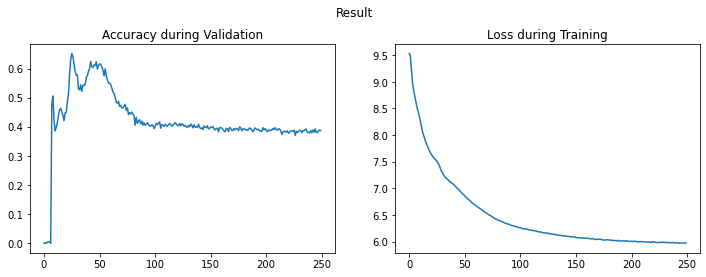

In [64]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()